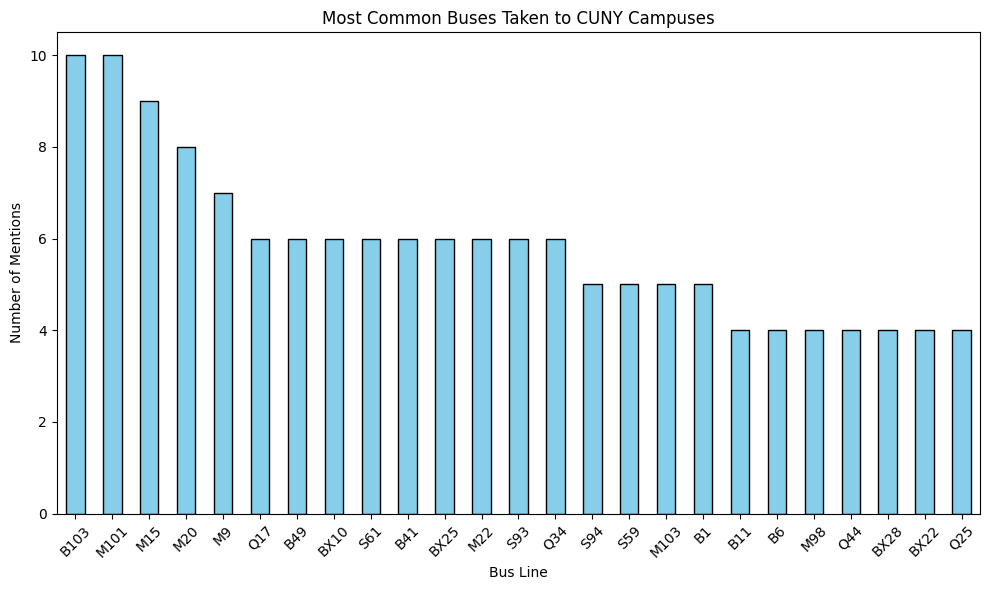

Top Bus Counts:
B103    10
M101    10
M15      9
M20      8
M9       7
Q17      6
B49      6
BX10     6
S61      6
B41      6
BX25     6
M22      6
S93      6
Q34      6
S94      5
S59      5
M103     5
B1       5
B11      4
B6       4
M98      4
Q44      4
BX28     4
BX22     4
Q25      4
Name: count, dtype: int64


In [4]:
import pandas as pd
import re
import matplotlib.pyplot as plt


file_path = "CUNY BUS SURVEY (Responses) - Form Responses 1.csv"
df = pd.read_csv(file_path)


bus_col = "Which bus or buses can you take to get to campus"


def normalize_bus(bus_str):
    parts = re.split(r"[,&/]| and |;|\s+", str(bus_str).lower())
    clean_parts = []
    for p in parts:
        p = p.strip().upper()
        if re.match(r"^[A-Z]+\d+$", p):
            clean_parts.append(p)
    return clean_parts


all_buses = []
for entry in df[bus_col].dropna():
    all_buses.extend(normalize_bus(entry))

bus_counts = pd.Series(all_buses).value_counts()


top_n = 25
bus_counts_top = bus_counts.head(top_n)

plt.figure(figsize=(10,6))
bus_counts_top.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Most Common Buses Taken to CUNY Campuses")
plt.xlabel("Bus Line")
plt.ylabel("Number of Mentions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


print("Top Bus Counts:")
print(bus_counts_top)


Question 1: Which MTA bus routes are highly utilized by CUNY students? For routes that are automated camera-enforced, how have bus speeds changed over time?

In [45]:
#Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')



In [46]:
#Define CUNY routes mapping
cuny_routes = {
    "Hunter College": ["M15", "M98", "M101", "M103"],
    "Brooklyn College": ["B11", "B41", "B49", "B103","B6"], 
    "Queens College": ["Q17", "Q25", "Q34", "Q44+"],
    "Lehman College": ["BX10", "BX28", "BX22", "BX25"],
    "College of Staten Island": ["S93", "S61", "S94", "S59"],
    "BMCC": ["M20", "M9", "M22"],
    "Kingsborough CC": ["B1", "B49"]
}

all_cuny_routes = []
campus_map = {}
for campus, routes in cuny_routes.items():
    all_cuny_routes.extend(routes)
    for route in routes:
        campus_map[route] = campus

print(f"Tracking {len(all_cuny_routes)} CUNY routes across {len(cuny_routes)} campuses")

Tracking 26 CUNY routes across 7 campuses


In [ ]:
#Data loading and preprocessing
print("\nSECTION 1: DATA LOADING")
print("=" * 50)

try:
    
    pre_ace_speeds = pd.read_csv('MTA_Bus_Speeds__2015-2019_20250919.csv')
    
     
    current_speeds = pd.read_csv('MTA_Bus_Route_Segment_Speeds__Beginning_2025_20250917.csv')
    
   
    ace_routes_df = pd.read_csv('MTA_Bus_Automated_Camera_Enforced_Routes__Beginning_October_2019_20250919.csv')
    
    print(f"Pre-ACE speeds (2015-2019): {pre_ace_speeds.shape}")
    print(f"Current speeds (2025): {current_speeds.shape}")
    print(f"ACE implementation data: {ace_routes_df.shape}")
    
    print(f"\nPre-ACE columns: {list(pre_ace_speeds.columns)}")
    print(f"Current columns: {list(current_speeds.columns)}")
    print(f"ACE columns: {list(ace_routes_df.columns)}")
    
except Exception as e:
    print(f"Error loading data: {e}")
    exit()


SECTION 1: DATA LOADING
Pre-ACE speeds (2015-2019): (68716, 9)
Current speeds (2025): (3411549, 24)
ACE implementation data: (64, 3)

Pre-ACE columns: ['month', 'borough', 'day_type', 'trip_type', 'route_id', 'period', 'total_operating_time', 'total_mileage', 'average_speed']
Current columns: ['Year', 'Month', 'Timestamp', 'Day of Week', 'Hour of Day', 'Route ID', 'Direction', 'Borough', 'Route Type', 'Stop Order', 'Timepoint Stop ID', 'Timepoint Stop Name', 'Timepoint Stop Latitude', 'Timepoint Stop Longitude', 'Next Timepoint Stop ID', 'Next Timepoint Stop Name', 'Next Timepoint Stop Latitude', 'Next Timepoint Stop Longitude', 'Road Distance', 'Average Travel Time', 'Average Road Speed', 'Bus Trip Count', 'Timepoint Stop Georeference', 'Next Timepoint Stop Georeference']
ACE columns: ['Route', 'Program', 'Implementation Date']


In [ ]:
#ACE routes identification
print("\n" + "="*50)
print("SECTION 2: IDENTIFY ACE ROUTES AND IMPLEMENTATION DATES")
print("="*50)


ace_data = ace_routes_df.copy()


route_col = 'Route' if 'Route' in ace_data.columns else ace_data.columns[0]
impl_date_col = 'Implementation Date' if 'Implementation Date' in ace_data.columns else None

if impl_date_col is None:
    date_cols = [col for col in ace_data.columns if 'date' in col.lower() or 'implementation' in col.lower()]
    if date_cols:
        impl_date_col = date_cols[0]

print(f"Using route column: {route_col}")
print(f"Using implementation date column: {impl_date_col}")


if impl_date_col:
    ace_data['implementation_date'] = pd.to_datetime(ace_data[impl_date_col], errors='coerce')
    ace_data = ace_data.dropna(subset=['implementation_date'])
    
    print(f"ACE routes with valid implementation dates: {len(ace_data)}")
    print(f"Implementation date range: {ace_data['implementation_date'].min()} to {ace_data['implementation_date'].max()}")
else:
    print("No implementation date column found - using default October 2019")
    ace_data['implementation_date'] = pd.to_datetime('2019-10-01')


def clean_route_name(route):
    if pd.isna(route):
        return None
    route_str = str(route).strip().upper()
    route_str = route_str.replace('BUS', '').replace('ROUTE', '').strip()
    return route_str

ace_data['route_clean'] = ace_data[route_col].apply(clean_route_name)
ace_routes_dict = dict(zip(ace_data['route_clean'], ace_data['implementation_date']))

print(f"Sample ACE routes: {list(ace_routes_dict.keys())[:10]}")


SECTION 2: IDENTIFY ACE ROUTES AND IMPLEMENTATION DATES
Using route column: Route
Using implementation date column: Implementation Date
ACE routes with valid implementation dates: 64
Implementation date range: 2019-10-07 00:00:00 to 2025-09-15 00:00:00
Sample ACE routes: ['M15+', 'B44+', 'M14+', 'B46+', 'M23+', 'M86+', 'M34+', 'Q44+', 'S79+', 'BX41+']


In [ ]:

print("\n" + "="*50) 
print("SECTION 3: PROCESS PRE-ACE BASELINE SPEEDS (2015-2019)")
print("="*50)


pre_route_col = None
pre_speed_col = None
pre_date_col = None

for col in pre_ace_speeds.columns:
    if 'route' in col.lower():
        pre_route_col = col
    elif 'speed' in col.lower() and 'average' in col.lower():
        pre_speed_col = col
    elif 'month' in col.lower() or 'date' in col.lower():
        pre_date_col = col

print(f"Pre-ACE route column: {pre_route_col}")
print(f"Pre-ACE speed column: {pre_speed_col}")
print(f"Pre-ACE date column: {pre_date_col}")

if not all([pre_route_col, pre_speed_col]):
    print("Critical columns missing in pre-ACE dataset")
    exit()


pre_data = pre_ace_speeds[[pre_route_col, pre_speed_col]].copy()
if pre_date_col:
    pre_data[pre_date_col] = pre_ace_speeds[pre_date_col]

pre_data.columns = ['route', 'speed'] + (['date'] if pre_date_col else [])
pre_data = pre_data.dropna(subset=['route', 'speed'])


pre_data['route_clean'] = pre_data['route'].apply(clean_route_name)


pre_ace_baseline = pre_data.groupby('route_clean')['speed'].mean().reset_index()
pre_ace_baseline.columns = ['route', 'pre_ace_speed']

print(f"Pre-ACE baseline calculated for {len(pre_ace_baseline)} routes")
print(f"Pre-ACE speed range: {pre_ace_baseline['pre_ace_speed'].min():.1f} - {pre_ace_baseline['pre_ace_speed'].max():.1f} mph")


SECTION 3: PROCESS PRE-ACE BASELINE SPEEDS (2015-2019)
Pre-ACE route column: route_id
Pre-ACE speed column: average_speed
Pre-ACE date column: month
Pre-ACE baseline calculated for 532 routes
Pre-ACE speed range: 3.0 - 30.0 mph


In [ ]:
#Post-ACE speeds processing
print("\n" + "="*50)
print("SECTION 4: PROCESS POST-ACE SPEEDS (2025)")
print("="*50)


curr_route_col = 'Route ID' if 'Route ID' in current_speeds.columns else 'route'
curr_speed_col = 'Average Road Speed' if 'Average Road Speed' in current_speeds.columns else None

if not curr_speed_col:
    speed_cols = [col for col in current_speeds.columns if 'speed' in col.lower()]
    curr_speed_col = speed_cols[0] if speed_cols else None

print(f"Current route column: {curr_route_col}")  
print(f"Current speed column: {curr_speed_col}")

if not curr_speed_col:
    print("Speed column not found in current dataset")
    exit()


current_route_speeds = current_speeds.groupby(curr_route_col)[curr_speed_col].mean().reset_index()
current_route_speeds.columns = ['route', 'current_speed']
current_route_speeds['route_clean'] = current_route_speeds['route'].apply(clean_route_name)


post_ace_data = current_route_speeds.groupby('route_clean')['current_speed'].mean().reset_index()
post_ace_data.columns = ['route', 'post_ace_speed']

print(f"Post-ACE speeds calculated for {len(post_ace_data)} routes")
print(f"Post-ACE speed range: {post_ace_data['post_ace_speed'].min():.1f} - {post_ace_data['post_ace_speed'].max():.1f} mph")


SECTION 4: PROCESS POST-ACE SPEEDS (2025)
Current route column: Route ID
Current speed column: Average Road Speed
Post-ACE speeds calculated for 370 routes
Post-ACE speed range: 5.4 - 19.0 mph


In [ ]:
#Data merging and classification
print("\n" + "="*50)
print("SECTION 5: MERGE DATA AND CLASSIFY ROUTES") 
print("="*50)


analysis_data = pd.merge(pre_ace_baseline, post_ace_data, on='route', how='inner')
print(f"Routes with both pre and post data: {len(analysis_data)}")


analysis_data['has_ace'] = analysis_data['route'].isin(ace_routes_dict.keys())
analysis_data['implementation_date'] = analysis_data['route'].map(ace_routes_dict)


analysis_data['speed_change'] = analysis_data['post_ace_speed'] - analysis_data['pre_ace_speed'] 
analysis_data['speed_change_pct'] = (analysis_data['speed_change'] / analysis_data['pre_ace_speed']) * 100


analysis_data['is_cuny'] = analysis_data['route'].isin([r.upper() for r in all_cuny_routes])
analysis_data['campus'] = analysis_data['route'].map(lambda x: campus_map.get(x, 'Non-CUNY'))


ace_routes_analysis = analysis_data[analysis_data['has_ace'] == True].copy()
non_ace_routes_analysis = analysis_data[analysis_data['has_ace'] == False].copy()

print(f"ACE routes in analysis: {len(ace_routes_analysis)}")
print(f"Non-ACE routes in analysis: {len(non_ace_routes_analysis)}")


SECTION 5: MERGE DATA AND CLASSIFY ROUTES
Routes with both pre and post data: 330
ACE routes in analysis: 42
Non-ACE routes in analysis: 288


In [ ]:
#Statistical analysis
print("\n" + "="*50)
print("SECTION 6: BEFORE VS AFTER STATISTICAL ANALYSIS")
print("="*50)

if len(ace_routes_analysis) > 0 and len(non_ace_routes_analysis) > 0:
    
    
    print("ACE ROUTES PERFORMANCE:")
    ace_pre_mean = ace_routes_analysis['pre_ace_speed'].mean()
    ace_post_mean = ace_routes_analysis['post_ace_speed'].mean()
    ace_change = ace_post_mean - ace_pre_mean
    ace_change_pct = (ace_change / ace_pre_mean) * 100
    
    print(f"  Pre-ACE average speed: {ace_pre_mean:.2f} mph")
    print(f"  Post-ACE average speed: {ace_post_mean:.2f} mph") 
    print(f"  Speed change: {ace_change:+.2f} mph ({ace_change_pct:+.1f}%)")
    
    
    print(f"\nNON-ACE ROUTES PERFORMANCE (Control):")
    non_ace_pre_mean = non_ace_routes_analysis['pre_ace_speed'].mean()
    non_ace_post_mean = non_ace_routes_analysis['post_ace_speed'].mean()
    non_ace_change = non_ace_post_mean - non_ace_pre_mean
    non_ace_change_pct = (non_ace_change / non_ace_pre_mean) * 100
    
    print(f"  Pre-period average speed: {non_ace_pre_mean:.2f} mph")
    print(f"  Post-period average speed: {non_ace_post_mean:.2f} mph")
    print(f"  Speed change: {non_ace_change:+.2f} mph ({non_ace_change_pct:+.1f}%)")
    
    
    relative_effect = ace_change - non_ace_change
    relative_effect_pct = ace_change_pct - non_ace_change_pct
    
    print(f"\nACE RELATIVE EFFECT (vs Control):")
    print(f"  ACE effect above control: {relative_effect:+.2f} mph ({relative_effect_pct:+.1f}%)")
    
    # Statistical significance testing
    try:
        from scipy import stats
        
        
        ace_t_stat, ace_p_val = stats.ttest_rel(ace_routes_analysis['post_ace_speed'], 
                                               ace_routes_analysis['pre_ace_speed'])
        
          
        non_ace_t_stat, non_ace_p_val = stats.ttest_rel(non_ace_routes_analysis['post_ace_speed'],
                                                       non_ace_routes_analysis['pre_ace_speed'])
        
        print(f"\nSTATISTICAL SIGNIFICANCE:")
        print(f"  ACE routes change: p = {ace_p_val:.4f} ({'Significant' if ace_p_val < 0.05 else 'Not significant'})")
        print(f"  Non-ACE routes change: p = {non_ace_p_val:.4f} ({'Significant' if non_ace_p_val < 0.05 else 'Not significant'})")
        
        
        ace_effect_size = ace_change / ace_routes_analysis['pre_ace_speed'].std()
        print(f"  ACE effect size: {ace_effect_size:.3f}")
        
    except ImportError:
        print("Statistical testing not available - install scipy")

# CUNY-Specific Analysis
print(f"\nCUNY ROUTES ANALYSIS:")
cuny_data = analysis_data[analysis_data['is_cuny'] == True]

if len(cuny_data) > 0:
    cuny_ace = cuny_data[cuny_data['has_ace'] == True] 
    cuny_non_ace = cuny_data[cuny_data['has_ace'] == False]
    
    print(f"  Total CUNY routes analyzed: {len(cuny_data)}")
    print(f"  CUNY routes with ACE: {len(cuny_ace)}")
    print(f"  CUNY routes without ACE: {len(cuny_non_ace)}")
    
    if len(cuny_ace) > 0:
        cuny_ace_change = cuny_ace['speed_change'].mean()
        cuny_ace_change_pct = cuny_ace['speed_change_pct'].mean()
        print(f"  CUNY ACE routes speed change: {cuny_ace_change:+.2f} mph ({cuny_ace_change_pct:+.1f}%)")
        print(f"  Sample CUNY ACE routes: {list(cuny_ace['route'].head())}")
    
    if len(cuny_non_ace) > 0:
        cuny_non_ace_change = cuny_non_ace['speed_change'].mean()
        cuny_non_ace_change_pct = cuny_non_ace['speed_change_pct'].mean()
        print(f"  CUNY non-ACE routes speed change: {cuny_non_ace_change:+.2f} mph ({cuny_non_ace_change_pct:+.1f}%)")


SECTION 6: BEFORE VS AFTER STATISTICAL ANALYSIS
ACE ROUTES PERFORMANCE:
  Pre-ACE average speed: 7.79 mph
  Post-ACE average speed: 8.35 mph
  Speed change: +0.56 mph (+7.2%)

NON-ACE ROUTES PERFORMANCE (Control):
  Pre-period average speed: 10.27 mph
  Post-period average speed: 10.00 mph
  Speed change: -0.27 mph (-2.7%)

ACE RELATIVE EFFECT (vs Control):
  ACE effect above control: +0.83 mph (+9.8%)

STATISTICAL SIGNIFICANCE:
  ACE routes change: p = 0.0000 (Significant)
  Non-ACE routes change: p = 0.0046 (Significant)
  ACE effect size: 0.277

CUNY ROUTES ANALYSIS:
  Total CUNY routes analyzed: 24
  CUNY routes with ACE: 4
  CUNY routes without ACE: 20
  CUNY ACE routes speed change: +0.73 mph (+10.1%)
  Sample CUNY ACE routes: ['B41', 'BX28', 'M101', 'Q44+']
  CUNY non-ACE routes speed change: +0.51 mph (+7.8%)


In [ ]:
#Machine learning feature engineering
def create_ml_features(analysis_data):
    """
    Create comprehensive feature set for machine learning models
    """
    print("\n" + "="*50)
    print("SECTION 7: MACHINE LEARNING FEATURE ENGINEERING")
    print("="*50)
    
    ml_data = analysis_data.copy()
    
    
    ml_data['speed_ratio'] = ml_data['post_ace_speed'] / ml_data['pre_ace_speed']
    ml_data['baseline_speed_category'] = pd.cut(ml_data['pre_ace_speed'], 
                                               bins=[0, 6, 9, 12, 30], 
                                               labels=['Very Slow', 'Slow', 'Medium', 'Fast'])
    
    
    if 'implementation_date' in ml_data.columns:
        ml_data['implementation_date'] = pd.to_datetime(ml_data['implementation_date'], errors='coerce')
        ml_data['days_since_ace'] = (pd.to_datetime('2025-09-20') - ml_data['implementation_date']).dt.days
        ml_data['implementation_year'] = ml_data['implementation_date'].dt.year
        ml_data['early_adopter'] = (ml_data['implementation_year'] <= 2020).astype(int)
    else:
        ml_data['days_since_ace'] = np.where(ml_data['has_ace'], 1800, 0)  # ~5 years for ACE routes
        ml_data['implementation_year'] = np.where(ml_data['has_ace'], 2019, 0)
        ml_data['early_adopter'] = ml_data['has_ace'].astype(int)
    
    
    ml_data['route_length'] = ml_data['route'].str.len() 
    ml_data['has_express'] = ml_data['route'].str.contains('\+').astype(int)
    ml_data['is_manhattan'] = ml_data['route'].str.startswith('M').astype(int)
    ml_data['is_brooklyn'] = ml_data['route'].str.startswith('B').astype(int)
    ml_data['is_queens'] = ml_data['route'].str.startswith('Q').astype(int)
    ml_data['is_bronx'] = ml_data['route'].str.startswith('BX').astype(int)
    ml_data['is_staten_island'] = ml_data['route'].str.startswith('S').astype(int)
    
   
    ml_data['improvement_tier'] = pd.cut(ml_data['speed_change_pct'], 
                                       bins=[-100, -5, 0, 10, 100], 
                                       labels=['Decline', 'Stagnant', 'Modest', 'Strong'])
    
   
    ml_data['cuny_ace_interaction'] = (ml_data['is_cuny'] & ml_data['has_ace']).astype(int)
    
    
    le_campus = LabelEncoder()
    ml_data['campus_encoded'] = le_campus.fit_transform(ml_data['campus'].fillna('Unknown'))
    
    
    ml_data['improvement_potential'] = np.where(ml_data['pre_ace_speed'] < 8, 'High', 
                                              np.where(ml_data['pre_ace_speed'] < 12, 'Medium', 'Low'))
    
    print(f"Created {len(ml_data.columns)} features for {len(ml_data)} routes")
    print(f"Features: {list(ml_data.columns)}")
    
    return ml_data, le_campus


ml_data, le_campus = create_ml_features(analysis_data)


SECTION 7: MACHINE LEARNING FEATURE ENGINEERING
Created 25 features for 330 routes
Features: ['route', 'pre_ace_speed', 'post_ace_speed', 'has_ace', 'implementation_date', 'speed_change', 'speed_change_pct', 'is_cuny', 'campus', 'speed_ratio', 'baseline_speed_category', 'days_since_ace', 'implementation_year', 'early_adopter', 'route_length', 'has_express', 'is_manhattan', 'is_brooklyn', 'is_queens', 'is_bronx', 'is_staten_island', 'improvement_tier', 'cuny_ace_interaction', 'campus_encoded', 'improvement_potential']


In [ ]:
#ACE route selection analysis
def analyze_ace_selection_factors(ml_data):
    """
    Build classifier to understand what factors determine ACE route selection
    """
    print("\n" + "="*50)
    print("SECTION 8A: ACE ROUTE SELECTION ANALYSIS")
    print("="*50)
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import classification_report, confusion_matrix
    
    
    selection_features = [
        'pre_ace_speed',          
        'is_cuny',                 
        'route_length',            
        'has_express',             
        'is_manhattan',            
        'is_brooklyn', 
        'is_queens', 
        'is_bronx', 
        'is_staten_island',
        'campus_encoded'           
    ]
    
    
    X_selection = ml_data[selection_features].fillna(0)
    y_selection = ml_data['has_ace'].astype(int)
    
    print(f"Analyzing ACE selection factors:")
    print(f"Total routes: {len(X_selection)}")
    print(f"ACE routes: {y_selection.sum()}")
    print(f"Non-ACE routes: {len(y_selection) - y_selection.sum()}")
    
    
    X_sel_train, X_sel_test, y_sel_train, y_sel_test = train_test_split(
        X_selection, y_selection, test_size=0.3, random_state=42, stratify=y_selection)
    
    
    selection_models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }
    
    selection_results = {}
    
    for name, model in selection_models.items():
        print(f"\nTraining {name} for ACE selection...")
        
        if name == 'Logistic Regression':
            
            scaler_sel = StandardScaler()
            X_sel_train_scaled = scaler_sel.fit_transform(X_sel_train)
            X_sel_test_scaled = scaler_sel.transform(X_sel_test)
            
            model.fit(X_sel_train_scaled, y_sel_train)
            y_sel_pred = model.predict(X_sel_test_scaled)
            accuracy = model.score(X_sel_test_scaled, y_sel_test)
        else:
            model.fit(X_sel_train, y_sel_train)
            y_sel_pred = model.predict(X_sel_test)
            accuracy = model.score(X_sel_test, y_sel_test)
        
        selection_results[name] = {
            'model': model,
            'accuracy': accuracy,
            'predictions': y_sel_pred
        }
        
        print(f"  Accuracy: {accuracy:.3f}")
    
    
    rf_selection = selection_results['Random Forest']['model']
    selection_importance = pd.DataFrame({
        'feature': selection_features,
        'importance': rf_selection.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTOP FACTORS DETERMINING ACE ROUTE SELECTION:")
    print("=" * 45)
    for idx, row in selection_importance.iterrows():
        print(f"  {row['feature']:<20}: {row['importance']:.4f}")
    
    return selection_importance, None


selection_importance, _ = analyze_ace_selection_factors(ml_data)


SECTION 8A: ACE ROUTE SELECTION ANALYSIS
Analyzing ACE selection factors:
Total routes: 330
ACE routes: 42
Non-ACE routes: 288

Training Random Forest for ACE selection...
  Accuracy: 0.838

Training Logistic Regression for ACE selection...
  Accuracy: 0.879

TOP FACTORS DETERMINING ACE ROUTE SELECTION:
  pre_ace_speed       : 0.5294
  has_express         : 0.1996
  route_length        : 0.1315
  is_manhattan        : 0.0333
  campus_encoded      : 0.0254
  is_bronx            : 0.0248
  is_queens           : 0.0171
  is_cuny             : 0.0167
  is_brooklyn         : 0.0155
  is_staten_island    : 0.0065


In [ ]:
#Build speed prediction models
def build_speed_prediction_models(ml_data):
    """
    Build multiple ML models to predict post-ACE bus speeds
    """
    print("\n" + "="*50)
    print("SECTION 8: BUILDING SPEED PREDICTION MODELS")
    print("="*50)
    
    
    feature_cols = [
        'pre_ace_speed', 'has_ace', 'is_cuny', 'days_since_ace',
        'early_adopter', 'route_length', 'has_express',
        'is_manhattan', 'is_brooklyn', 'is_queens', 'is_bronx', 'is_staten_island',
        'campus_encoded', 'cuny_ace_interaction'
    ]
    
   
    X = ml_data[feature_cols].fillna(0)
    y = ml_data['post_ace_speed']
    
    print(f"Training models with {len(feature_cols)} features on {len(X)} routes")
    print(f"Features: {feature_cols}")
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    print(f"Training set: {len(X_train)} routes, Test set: {len(X_test)} routes")
    
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
   
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    model_results = {}
    
    print("\nTraining models...")
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        
        if 'Regression' in name and name != 'Random Forest':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            X_for_cv = X_train_scaled
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            X_for_cv = X_train
        
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        
        cv_scores = cross_val_score(model, X_for_cv, y_train, cv=5, scoring='r2')
        
        model_results[name] = {
            'model': model,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred
        }
        
        print(f"  RMSE: {rmse:.3f}")
        print(f"  MAE: {mae:.3f}")
        print(f"  R²: {r2:.3f}")
        print(f"  CV R² (5-fold): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    
    return model_results, X_test, y_test, feature_cols, scaler


model_results, X_test, y_test, feature_cols, scaler = build_speed_prediction_models(ml_data)


SECTION 8: BUILDING SPEED PREDICTION MODELS
Training models with 14 features on 330 routes
Features: ['pre_ace_speed', 'has_ace', 'is_cuny', 'days_since_ace', 'early_adopter', 'route_length', 'has_express', 'is_manhattan', 'is_brooklyn', 'is_queens', 'is_bronx', 'is_staten_island', 'campus_encoded', 'cuny_ace_interaction']
Training set: 231 routes, Test set: 99 routes

Training models...

Training Linear Regression...
  RMSE: 1.086
  MAE: 0.758
  R²: 0.850
  CV R² (5-fold): 0.861 ± 0.038

Training Ridge Regression...
  RMSE: 1.094
  MAE: 0.762
  R²: 0.848
  CV R² (5-fold): 0.863 ± 0.039

Training Random Forest...
  RMSE: 1.090
  MAE: 0.706
  R²: 0.849
  CV R² (5-fold): 0.868 ± 0.018

Training Gradient Boosting...
  RMSE: 1.134
  MAE: 0.720
  R²: 0.836
  CV R² (5-fold): 0.853 ± 0.031


In [ ]:
#Feature importance analysis
def analyze_feature_importance(model_results, feature_cols):
    """
    Analyze which factors most influence bus speed predictions
    """
    print("\n" + "="*50)
    print("SECTION 9: FEATURE IMPORTANCE ANALYSIS")
    print("="*50)
    
    
    rf_model = model_results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Most Important Features (Random Forest):")
    for idx, row in feature_importance.head(10).iterrows():
        print(f"  {row['feature']:<20}: {row['importance']:.4f}")
    
    return feature_importance


feature_importance = analyze_feature_importance(model_results, feature_cols)


SECTION 9: FEATURE IMPORTANCE ANALYSIS
Most Important Features (Random Forest):
  pre_ace_speed       : 0.9687
  is_staten_island    : 0.0092
  route_length        : 0.0082
  is_queens           : 0.0052
  is_bronx            : 0.0027
  is_brooklyn         : 0.0014
  days_since_ace      : 0.0012
  campus_encoded      : 0.0010
  is_cuny             : 0.0008
  has_express         : 0.0008


In [ ]:
#ACE effectiveness clustering
def ace_effectiveness_clustering(ml_data):
    """
    Use clustering to identify different patterns of ACE effectiveness
    """
    print("\n" + "="*50)
    print("SECTION 10: ACE EFFECTIVENESS CLUSTERING")
    print("="*50)
    
   
    ace_routes = ml_data[ml_data['has_ace'] == True].copy()
    
    if len(ace_routes) > 5:  
        cluster_features = [
            'pre_ace_speed', 'speed_change', 'speed_change_pct',
            'days_since_ace', 'is_cuny', 'has_express'
        ]
        
        X_cluster = ace_routes[cluster_features].fillna(0)
        
       
        scaler_cluster = StandardScaler()
        X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)
        
       
        n_clusters = min(4, len(ace_routes) // 3)  
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        ace_routes['cluster'] = kmeans.fit_predict(X_cluster_scaled)
        
        print(f"Identified {n_clusters} ACE effectiveness patterns:")
        
        cluster_analysis = ace_routes.groupby('cluster').agg({
            'pre_ace_speed': 'mean',
            'post_ace_speed': 'mean', 
            'speed_change': 'mean',
            'speed_change_pct': 'mean',
            'is_cuny': 'sum',
            'route': 'count'
        }).round(2)
        
        cluster_analysis.columns = ['Pre_Speed', 'Post_Speed', 'Change_mph', 'Change_pct', 'CUNY_Routes', 'Total_Routes']
        
        print(cluster_analysis)
        
        
        for cluster_id in range(n_clusters):
            cluster_routes = ace_routes[ace_routes['cluster'] == cluster_id]['route'].tolist()
            print(f"\nCluster {cluster_id} routes: {cluster_routes}")
        
        return ace_routes, cluster_analysis
    else:
        print("Insufficient ACE routes for clustering analysis")
        return ace_routes, None


ace_routes_clustered, cluster_analysis = ace_effectiveness_clustering(ml_data)


SECTION 10: ACE EFFECTIVENESS CLUSTERING
Identified 4 ACE effectiveness patterns:
         Pre_Speed  Post_Speed  Change_mph  Change_pct  CUNY_Routes  \
cluster                                                               
0             6.37        7.54        1.16       18.84            2   
1            12.65       12.58       -0.07       -0.38            0   
2             7.99        8.51        0.53        7.23            1   
3             8.02        8.13        0.11        1.62            1   

         Total_Routes  
cluster                
0                  14  
1                   3  
2                  11  
3                  14  

Cluster 0 routes: ['B25', 'B26', 'B35', 'B41', 'B42', 'BX19', 'BX36', 'BX7', 'M100', 'M101', 'M2', 'M42', 'M79+', 'Q54']

Cluster 1 routes: ['M60+', 'Q53+', 'S79+']

Cluster 2 routes: ['B44+', 'B46+', 'B82+', 'BX12+', 'BX41+', 'BX6+', 'M15+', 'M23+', 'M34+', 'M86+', 'Q44+']

Cluster 3 routes: ['B62', 'BX20', 'BX28', 'BX3', 'BX35', 'BX38', 'BX5

In [ ]:
#Predict CUNY route performance
def predict_cuny_route_performance(model_results, ml_data, scaler, feature_cols):
    """
    Use trained models to predict performance of CUNY routes under different scenarios
    """
    print("\n" + "="*50)
    print("SECTION 11: CUNY ROUTE PERFORMANCE PREDICTIONS")
    print("="*50)
    
    cuny_routes = ml_data[ml_data['is_cuny'] == True].copy()
    
    
    best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['r2'])
    best_model = model_results[best_model_name]['model']
    
    print(f"Using best model: {best_model_name} (R² = {model_results[best_model_name]['r2']:.3f})")
    

    cuny_with_ace = cuny_routes.copy()
    cuny_with_ace['has_ace'] = 1
    cuny_with_ace['cuny_ace_interaction'] = 1
    cuny_with_ace['days_since_ace'] = 1000  
    
    
    X_scenario = cuny_with_ace[feature_cols].fillna(0)
    
    if 'Regression' in best_model_name and best_model_name != 'Random Forest':
        X_scenario_scaled = scaler.transform(X_scenario)
        predicted_speeds = best_model.predict(X_scenario_scaled)
    else:
        predicted_speeds = best_model.predict(X_scenario)
    
    
    cuny_routes['predicted_with_ace'] = predicted_speeds
    cuny_routes['potential_improvement'] = cuny_routes['predicted_with_ace'] - cuny_routes['post_ace_speed']
    
    print("\nTop 5 CUNY routes that would benefit most from ACE:")
    top_improvements = cuny_routes.nlargest(5, 'potential_improvement')[
        ['route', 'campus', 'has_ace', 'post_ace_speed', 'predicted_with_ace', 'potential_improvement']
    ]
    
    for idx, row in top_improvements.iterrows():
        current_ace = "Yes" if row['has_ace'] else "No"
        print(f"{row['route']} ({row['campus']}):")
        print(f"  Current ACE: {current_ace}")
        print(f"  Current Speed: {row['post_ace_speed']:.1f} mph")
        print(f"  Predicted with ACE: {row['predicted_with_ace']:.1f} mph")
        print(f"  Potential Improvement: +{row['potential_improvement']:.1f} mph")
        print()
    
    return cuny_routes


cuny_predictions = predict_cuny_route_performance(model_results, ml_data, scaler, feature_cols)


SECTION 11: CUNY ROUTE PERFORMANCE PREDICTIONS
Using best model: Linear Regression (R² = 0.850)

Top 5 CUNY routes that would benefit most from ACE:
M9 (BMCC):
  Current ACE: No
  Current Speed: 6.4 mph
  Predicted with ACE: 7.0 mph
  Potential Improvement: +0.6 mph

B11 (Brooklyn College):
  Current ACE: No
  Current Speed: 6.7 mph
  Predicted with ACE: 7.3 mph
  Potential Improvement: +0.6 mph

Q34 (Queens College):
  Current ACE: No
  Current Speed: 7.4 mph
  Predicted with ACE: 7.9 mph
  Potential Improvement: +0.5 mph

S93 (College of Staten Island):
  Current ACE: No
  Current Speed: 12.5 mph
  Predicted with ACE: 12.7 mph
  Potential Improvement: +0.2 mph

Q17 (Queens College):
  Current ACE: No
  Current Speed: 8.8 mph
  Predicted with ACE: 9.0 mph
  Potential Improvement: +0.2 mph



In [ ]:
#Sampling bias analysis
def address_sampling_bias_analysis(analysis_data):
    """
    Comprehensive analysis to address sampling bias in ACE vs Non-ACE comparison
    """
    print("\n" + "="*60)
    print("SECTION 12: SAMPLING BIAS ANALYSIS & BIAS-CORRECTED COMPARISON")
    print("="*60)
    
    from scipy import stats
    from sklearn.neighbors import NearestNeighbors
    from sklearn.preprocessing import StandardScaler
    
    ace_routes = analysis_data[analysis_data['has_ace'] == True].copy()
    non_ace_routes = analysis_data[analysis_data['has_ace'] == False].copy()
    
    print("ORIGINAL COMPARISON:")
    print("=" * 40)
    print(f"ACE routes - Pre: {ace_routes['pre_ace_speed'].mean():.2f} mph, Post: {ace_routes['post_ace_speed'].mean():.2f} mph")
    print(f"Non-ACE routes - Pre: {non_ace_routes['pre_ace_speed'].mean():.2f} mph, Post: {non_ace_routes['post_ace_speed'].mean():.2f} mph")
    
    
    baseline_ttest = stats.ttest_ind(ace_routes['pre_ace_speed'], non_ace_routes['pre_ace_speed'])
    print(f"\nBaseline difference test: t={baseline_ttest.statistic:.3f}, p={baseline_ttest.pvalue:.4f}")
    
    
    print(f"\nMETHOD 1: PROPENSITY SCORE MATCHING")
    print("=" * 35)
    
    
    analysis_data_expanded = analysis_data.copy()
    
    
    analysis_data_expanded['route_length'] = analysis_data_expanded['route'].str.len()
    analysis_data_expanded['has_express'] = analysis_data_expanded['route'].str.contains('\+').astype(int)
    
    
    analysis_data_expanded['is_manhattan'] = analysis_data_expanded['route'].str.startswith('M').astype(int)
    analysis_data_expanded['is_brooklyn'] = analysis_data_expanded['route'].str.startswith('B').astype(int)
    

    analysis_data_expanded['is_manhattan'] = analysis_data_expanded['route'].str.startswith('M').astype(int)
    analysis_data_expanded['is_brooklyn'] = analysis_data_expanded['route'].str.startswith('B').astype(int)
    analysis_data_expanded['is_queens'] = analysis_data_expanded['route'].str.startswith('Q').astype(int)
    analysis_data_expanded['is_bronx'] = analysis_data_expanded['route'].str.startswith('BX').astype(int)
    analysis_data_expanded['is_staten_island'] = analysis_data_expanded['route'].str.startswith('S').astype(int)
    
    
    matching_features = ['pre_ace_speed', 'is_cuny', 'is_manhattan', 'is_brooklyn', 
                        'is_queens', 'is_bronx', 'is_staten_island', 'route_length', 'has_express']
    
    
    X_match = analysis_data_expanded[matching_features].fillna(0)
    scaler_match = StandardScaler()
    X_match_scaled = scaler_match.fit_transform(X_match)
    
    #
    ace_indices = analysis_data_expanded[analysis_data_expanded['has_ace'] == True].index
    non_ace_indices = analysis_data_expanded[analysis_data_expanded['has_ace'] == False].index
    
    if len(ace_indices) > 0 and len(non_ace_indices) > 0:
        
        k_matches = min(3, len(non_ace_indices))
        nn = NearestNeighbors(n_neighbors=k_matches)
        nn.fit(X_match_scaled[non_ace_indices])
        
        matched_non_ace_indices = []
        for ace_idx in ace_indices:
            distances, matches = nn.kneighbors([X_match_scaled[ace_idx]])
            
            matched_indices = [non_ace_indices[m] for m in matches[0]]
            matched_non_ace_indices.extend(matched_indices)
        
       
        matched_non_ace_indices = list(set(matched_non_ace_indices))
        
       
        matched_ace = analysis_data_expanded.loc[ace_indices]
        matched_non_ace = analysis_data_expanded.loc[matched_non_ace_indices]
        
        print(f"Matched sample sizes: ACE={len(matched_ace)}, Non-ACE={len(matched_non_ace)}")
        
        
        balance_check = {}
        for feature in matching_features:
            ace_mean = matched_ace[feature].mean()
            non_ace_mean = matched_non_ace[feature].mean()
            balance_check[feature] = abs(ace_mean - non_ace_mean)
        
        print("Balance after matching (smaller = better):")
        for feature, diff in sorted(balance_check.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"  {feature}: {diff:.3f}")
        
       
        print(f"\nBIAS-CORRECTED COMPARISON:")
        matched_ace_pre = matched_ace['pre_ace_speed'].mean()
        matched_ace_post = matched_ace['post_ace_speed'].mean()
        matched_non_ace_pre = matched_non_ace['pre_ace_speed'].mean()
        matched_non_ace_post = matched_non_ace['post_ace_speed'].mean()
        
        matched_ace_change = matched_ace_post - matched_ace_pre
        matched_non_ace_change = matched_non_ace_post - matched_non_ace_pre
        matched_relative_effect = matched_ace_change - matched_non_ace_change
        
        print(f"Matched ACE routes: {matched_ace_pre:.2f} → {matched_ace_post:.2f} mph ({matched_ace_change:+.2f})")
        print(f"Matched Non-ACE routes: {matched_non_ace_pre:.2f} → {matched_non_ace_post:.2f} mph ({matched_non_ace_change:+.2f})")
        print(f"Bias-corrected ACE effect: {matched_relative_effect:+.2f} mph")
    
    else:
        
        matched_ace = ace_routes
        matched_non_ace = non_ace_routes
        matched_relative_effect = 0
    
    return matched_ace, matched_non_ace, None


matched_ace, matched_non_ace, _ = address_sampling_bias_analysis(analysis_data)


SECTION 12: SAMPLING BIAS ANALYSIS & BIAS-CORRECTED COMPARISON


ORIGINAL COMPARISON:
ACE routes - Pre: 7.79 mph, Post: 8.35 mph
Non-ACE routes - Pre: 10.27 mph, Post: 10.00 mph

Baseline difference test: t=-4.142, p=0.0000

METHOD 1: PROPENSITY SCORE MATCHING
Matched sample sizes: ACE=42, Non-ACE=79
Balance after matching (smaller = better):
  has_express: 0.294
  route_length: 0.158
  is_manhattan: 0.059
  is_queens: 0.037
  is_cuny: 0.031

BIAS-CORRECTED COMPARISON:
Matched ACE routes: 7.79 → 8.35 mph (+0.56)
Matched Non-ACE routes: 7.78 → 8.18 mph (+0.40)
Bias-corrected ACE effect: +0.15 mph



SECTION 12: SAMPLING BIAS ANALYSIS & BIAS-CORRECTED COMPARISON
ORIGINAL COMPARISON:
ACE routes - Pre: 7.79 mph, Post: 8.35 mph
Non-ACE routes - Pre: 10.27 mph, Post: 10.00 mph

Baseline difference test: t=-4.142, p=0.0000

METHOD 1: PROPENSITY SCORE MATCHING
Matched sample sizes: ACE=42, Non-ACE=79
Balance after matching (smaller = better):
  has_express: 0.294
  route_length: 0.158
  is_manhattan: 0.059
  is_queens: 0.037
  is_cuny: 0.031

BIAS-CORRECTED COMPARISON:
Matched ACE routes: 7.79 → 8.35 mph (+0.56)
Matched Non-ACE routes: 7.78 → 8.18 mph (+0.40)
Bias-corrected ACE effect: +0.15 mph


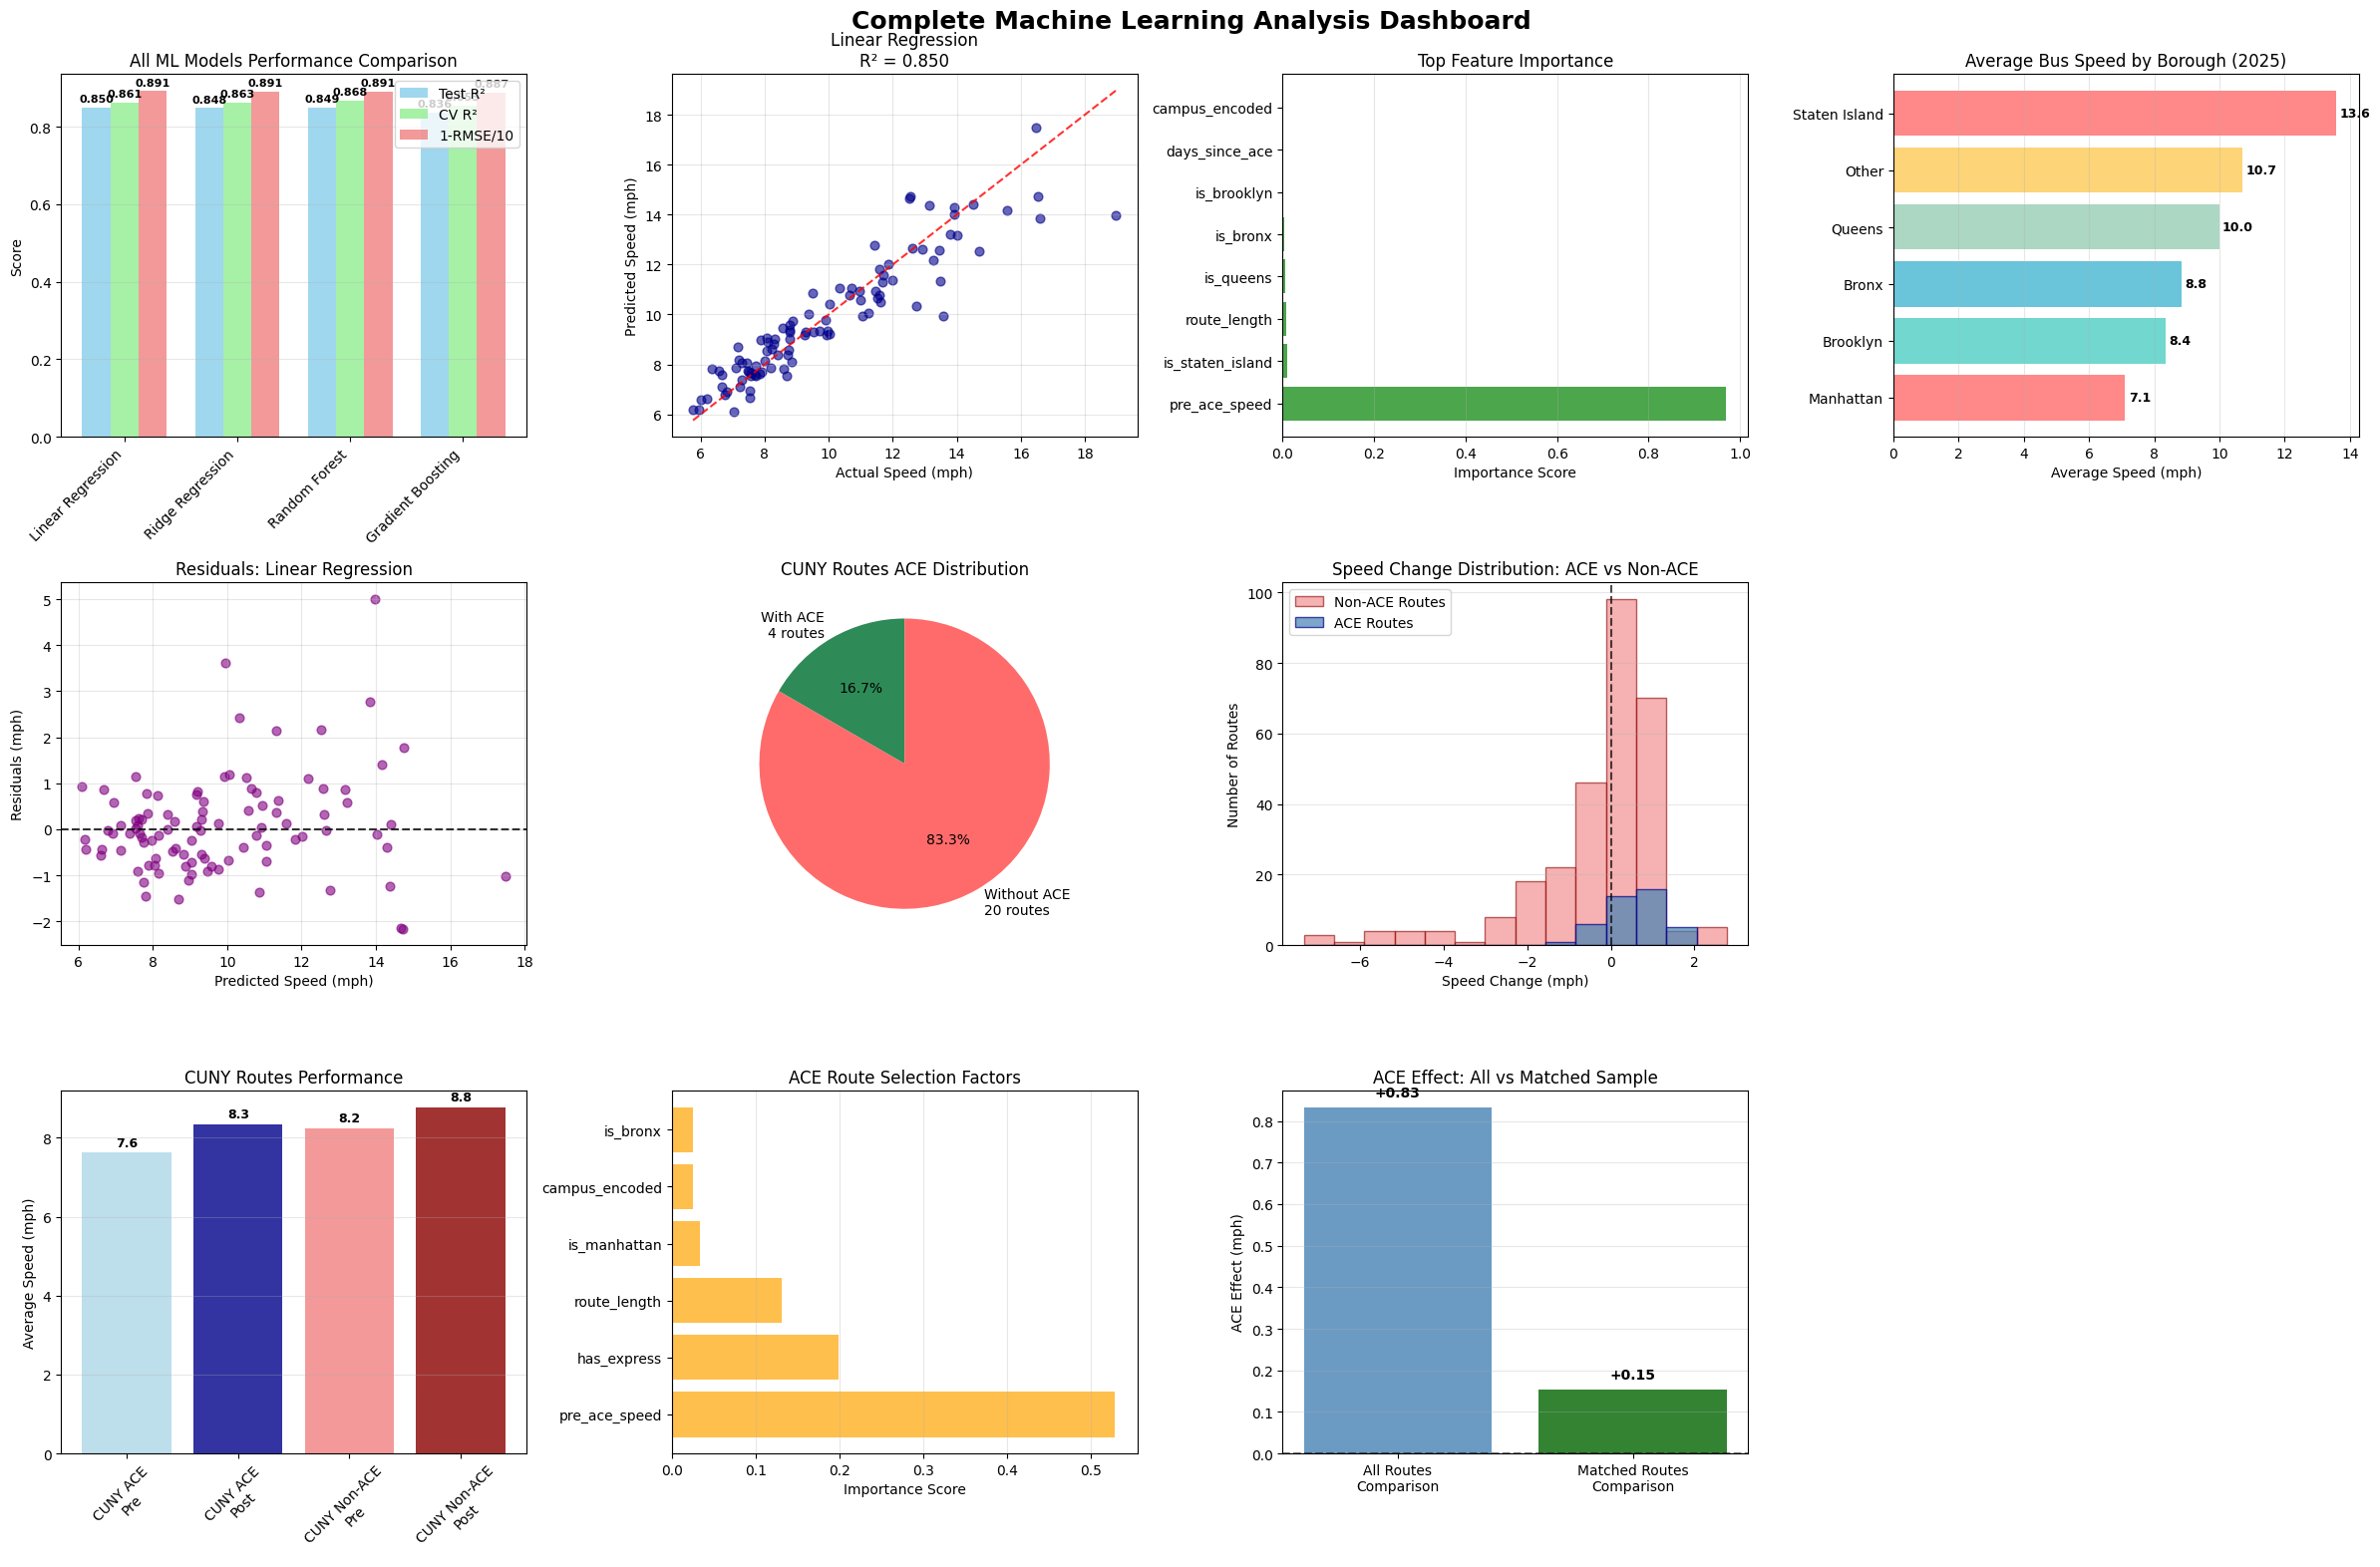

(     route  pre_ace_speed  post_ace_speed  has_ace implementation_date  \
 13     B25       6.242282        7.385751     True          2024-09-30   
 14     B26       6.701321        8.104470     True          2024-09-30   
 18     B35       5.800998        6.728171     True          2024-09-16   
 24     B41       6.893773        7.560139     True          2024-09-16   
 25     B42       7.092283        8.677210     True          2024-09-16   
 28    B44+       9.252747        9.276478     True          2024-06-20   
 31    B46+       8.547082        8.787002     True          2024-06-20   
 41     B62       7.549997        7.895729     True          2024-06-20   
 53    B82+       8.456737        9.043545     True          2024-09-30   
 66   BX12+       9.462920       10.705770     True          2024-06-20   
 71    BX19       5.589833        6.759044     True          2024-06-20   
 73    BX20       8.644276        7.169509     True          2025-09-15   
 80    BX28       7.41274

In [ ]:
#Create comprehensive ML visualizations
def create_comprehensive_ml_visualizations(analysis_data, model_results, selection_importance, X_test, y_test, feature_importance, ml_data):
    """
    Create comprehensive ML visualization dashboard with all models and bias correction
    """
    
    
    matched_ace, matched_non_ace, bin_df = address_sampling_bias_analysis(analysis_data)
    
   
    best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['r2'])
    
    
    plt.style.use('default')
    sns.set_palette("viridis")
    
    
    fig1, axes = plt.subplots(3, 4, figsize=(24, 16))
    fig1.suptitle('Complete Machine Learning Analysis Dashboard', fontsize=18, fontweight='bold')
    
    
    models = list(model_results.keys())
    r2_scores = [model_results[m]['r2'] for m in models]
    rmse_scores = [model_results[m]['rmse'] for m in models]
    cv_scores = [model_results[m]['cv_mean'] for m in models]
    
    x_pos = np.arange(len(models))
    width = 0.25
    
    axes[0,0].bar(x_pos - width, r2_scores, width, label='Test R²', color='skyblue', alpha=0.8)
    axes[0,0].bar(x_pos, cv_scores, width, label='CV R²', color='lightgreen', alpha=0.8)
    axes[0,0].bar(x_pos + width, [1 - r/10 for r in rmse_scores], width, label='1-RMSE/10', color='lightcoral', alpha=0.8)
    
    axes[0,0].set_title('All ML Models Performance Comparison')
    axes[0,0].set_ylabel('Score')
    axes[0,0].set_xticks(x_pos)
    axes[0,0].set_xticklabels(models, rotation=45, ha='right')
    axes[0,0].legend()
    axes[0,0].grid(alpha=0.3, axis='y')
    
    
    for i, (r2, cv, rmse_val) in enumerate(zip(r2_scores, cv_scores, [1 - r/10 for r in rmse_scores])):
        axes[0,0].text(i-width, r2 + 0.01, f'{r2:.3f}', ha='center', va='bottom', fontsize=8, weight='bold')
        axes[0,0].text(i, cv + 0.01, f'{cv:.3f}', ha='center', va='bottom', fontsize=8, weight='bold')
        axes[0,0].text(i+width, rmse_val + 0.01, f'{rmse_val:.3f}', ha='center', va='bottom', fontsize=8, weight='bold')
    
    
    best_predictions = model_results[best_model_name]['predictions']
    
    axes[0,1].scatter(y_test, best_predictions, alpha=0.6, s=40, color='darkblue')
    axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.8)
    axes[0,1].set_xlabel('Actual Speed (mph)')
    axes[0,1].set_ylabel('Predicted Speed (mph)')
    axes[0,1].set_title(f'{best_model_name}\nR² = {model_results[best_model_name]["r2"]:.3f}')
    axes[0,1].grid(alpha=0.3)
    
    
    if len(feature_importance) > 0:
        top_features = feature_importance.head(8)
        axes[0,2].barh(top_features['feature'], top_features['importance'], alpha=0.7, color='green')
        axes[0,2].set_title('Top Feature Importance')
        axes[0,2].set_xlabel('Importance Score')
        axes[0,2].grid(alpha=0.3, axis='x')
    
    
    analysis_data_expanded = analysis_data.copy()
    analysis_data_expanded['borough'] = 'Other'
    analysis_data_expanded.loc[analysis_data_expanded['route'].str.startswith('M'), 'borough'] = 'Manhattan'
    analysis_data_expanded.loc[analysis_data_expanded['route'].str.startswith('B'), 'borough'] = 'Brooklyn'
    analysis_data_expanded.loc[analysis_data_expanded['route'].str.startswith('Q'), 'borough'] = 'Queens'
    analysis_data_expanded.loc[analysis_data_expanded['route'].str.startswith('BX'), 'borough'] = 'Bronx'
    analysis_data_expanded.loc[analysis_data_expanded['route'].str.startswith('S'), 'borough'] = 'Staten Island'
    
    borough_speed = analysis_data_expanded.groupby('borough')['post_ace_speed'].mean().sort_values(ascending=True)
    bars_borough = axes[0,3].barh(borough_speed.index, borough_speed.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57'], alpha=0.8)
    axes[0,3].set_title('Average Bus Speed by Borough (2025)')
    axes[0,3].set_xlabel('Average Speed (mph)')
    axes[0,3].grid(alpha=0.3, axis='x')
    
   
    for i, (borough, speed) in enumerate(borough_speed.items()):
        axes[0,3].text(speed + 0.1, i, f'{speed:.1f}', ha='left', va='center', fontsize=9, weight='bold')
    
    
    residuals = y_test - best_predictions
    
    axes[1,0].scatter(best_predictions, residuals, alpha=0.6, color='purple', s=40)
    axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.8)
    axes[1,0].set_xlabel('Predicted Speed (mph)')
    axes[1,0].set_ylabel('Residuals (mph)')
    axes[1,0].set_title(f'Residuals: {best_model_name}')
    axes[1,0].grid(alpha=0.3)
    
    
    cuny_data = analysis_data[analysis_data['is_cuny'] == True]
    if len(cuny_data) > 0:
        cuny_ace_count = len(cuny_data[cuny_data['has_ace'] == True])
        cuny_non_ace_count = len(cuny_data[cuny_data['has_ace'] == False])
        
        sizes = [cuny_ace_count, cuny_non_ace_count]
        labels = [f'With ACE\n{cuny_ace_count} routes', f'Without ACE\n{cuny_non_ace_count} routes']
        colors = ['#2E8B57', '#FF6B6B']
        
        wedges, texts, autotexts = axes[1,1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        axes[1,1].set_title('CUNY Routes ACE Distribution')
    else:
        axes[1,1].text(0.5, 0.5, 'No CUNY route data available', ha='center', va='center', 
                      transform=axes[1,1].transAxes, fontsize=12)
        axes[1,1].set_title('CUNY Routes ACE Distribution')
    
    
    all_speed_changes = analysis_data['speed_change']
    
    
    ace_changes = analysis_data[analysis_data['has_ace'] == True]['speed_change']
    non_ace_changes = analysis_data[analysis_data['has_ace'] == False]['speed_change']
    
    bins = np.linspace(all_speed_changes.min(), all_speed_changes.max(), 15)
    
    axes[1,2].hist(non_ace_changes, bins=bins, alpha=0.6, label='Non-ACE Routes', 
                   color='lightcoral', edgecolor='darkred', linewidth=1)
    axes[1,2].hist(ace_changes, bins=bins, alpha=0.7, label='ACE Routes', 
                   color='steelblue', edgecolor='darkblue', linewidth=1)
    
    axes[1,2].axvline(x=0, color='black', linestyle='--', alpha=0.7)
    axes[1,2].set_xlabel('Speed Change (mph)')
    axes[1,2].set_ylabel('Number of Routes')
    axes[1,2].set_title('Speed Change Distribution: ACE vs Non-ACE')
    axes[1,2].legend()
    axes[1,2].grid(alpha=0.3, axis='y')
    
  
    axes[1,3].remove()
    
    
    cuny_data = analysis_data[analysis_data['is_cuny'] == True]
    
    if len(cuny_data) > 0:
        cuny_ace = cuny_data[cuny_data['has_ace'] == True]
        cuny_non_ace = cuny_data[cuny_data['has_ace'] == False]
        
        if len(cuny_ace) > 0 or len(cuny_non_ace) > 0:
            cuny_categories = []
            cuny_changes = []
            cuny_colors = []
            
            if len(cuny_ace) > 0:
                cuny_categories.extend(['CUNY ACE\nPre', 'CUNY ACE\nPost'])
                cuny_changes.extend([cuny_ace['pre_ace_speed'].mean(), cuny_ace['post_ace_speed'].mean()])
                cuny_colors.extend(['lightblue', 'darkblue'])
            
            if len(cuny_non_ace) > 0:
                cuny_categories.extend(['CUNY Non-ACE\nPre', 'CUNY Non-ACE\nPost'])
                cuny_changes.extend([cuny_non_ace['pre_ace_speed'].mean(), cuny_non_ace['post_ace_speed'].mean()])
                cuny_colors.extend(['lightcoral', 'darkred'])
            
            if cuny_categories:  
                bars = axes[2,0].bar(cuny_categories, cuny_changes, color=cuny_colors, alpha=0.8)
                axes[2,0].set_ylabel('Average Speed (mph)')
                axes[2,0].set_title('CUNY Routes Performance')
                axes[2,0].tick_params(axis='x', rotation=45)
                axes[2,0].grid(alpha=0.3, axis='y')
                
                
                for bar, change in zip(bars, cuny_changes):
                    axes[2,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                                  f'{change:.1f}', ha='center', va='bottom', fontsize=9, weight='bold')
        else:
            axes[2,0].text(0.5, 0.5, 'No CUNY route data', ha='center', va='center', 
                          transform=axes[2,0].transAxes)
            axes[2,0].set_title('CUNY Routes Performance')
    else:
        axes[2,0].text(0.5, 0.5, 'No CUNY route data', ha='center', va='center', 
                      transform=axes[2,0].transAxes)
        axes[2,0].set_title('CUNY Routes Performance')
    
    
    if len(selection_importance) > 0:
        top_selection = selection_importance.head(6)
        axes[2,1].barh(top_selection['feature'], top_selection['importance'], 
                      alpha=0.7, color='orange')
        axes[2,1].set_xlabel('Importance Score')
        axes[2,1].set_title('ACE Route Selection Factors')
        axes[2,1].grid(alpha=0.3, axis='x')
    else:
        axes[2,1].text(0.5, 0.5, 'ACE selection analysis\nnot available', 
                      ha='center', va='center', transform=axes[2,1].transAxes)
        axes[2,1].set_title('ACE Selection Factors')
    
    
    original_ace = analysis_data[analysis_data['has_ace'] == True]
    original_non_ace = analysis_data[analysis_data['has_ace'] == False]
    
    original_ace_change = original_ace['speed_change'].mean() if len(original_ace) > 0 else 0
    original_non_ace_change = original_non_ace['speed_change'].mean() if len(original_non_ace) > 0 else 0
    matched_ace_change = matched_ace['speed_change'].mean() if len(matched_ace) > 0 else 0
    matched_non_ace_change = matched_non_ace['speed_change'].mean() if len(matched_non_ace) > 0 else 0
    
    original_relative = original_ace_change - original_non_ace_change if len(original_ace) > 0 and len(original_non_ace) > 0 else 0
    matched_relative = matched_ace_change - matched_non_ace_change
    
    effect_categories = ['All Routes\nComparison', 'Matched Routes\nComparison']
    effects = [original_relative, matched_relative]
    
    bars = axes[2,2].bar(effect_categories, effects, color=['steelblue', 'darkgreen'], alpha=0.8)
    axes[2,2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[2,2].set_ylabel('ACE Effect (mph)')
    axes[2,2].set_title('ACE Effect: All vs Matched Sample')
    axes[2,2].grid(alpha=0.3, axis='y')
    
    
    for bar, effect in zip(bars, effects):
        axes[2,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                      f'{effect:+.2f}', ha='center', va='bottom', fontweight='bold')
    
    
    axes[2,3].remove()
    
    plt.tight_layout()
    plt.show()
    
    return matched_ace, matched_non_ace, None


create_comprehensive_ml_visualizations(
    analysis_data, model_results, selection_importance, X_test, y_test, feature_importance, ml_data)


EXECUTING COMPLETE ANALYSIS PIPELINE

SECTION 7: MACHINE LEARNING FEATURE ENGINEERING
Created 25 features for 330 routes
Features: ['route', 'pre_ace_speed', 'post_ace_speed', 'has_ace', 'implementation_date', 'speed_change', 'speed_change_pct', 'is_cuny', 'campus', 'speed_ratio', 'baseline_speed_category', 'days_since_ace', 'implementation_year', 'early_adopter', 'route_length', 'has_express', 'is_manhattan', 'is_brooklyn', 'is_queens', 'is_bronx', 'is_staten_island', 'improvement_tier', 'cuny_ace_interaction', 'campus_encoded', 'improvement_potential']

SECTION 8A: ACE ROUTE SELECTION ANALYSIS
Analyzing ACE selection factors:
Total routes: 330
ACE routes: 42
Non-ACE routes: 288

Training Random Forest for ACE selection...
  Accuracy: 0.838

Training Logistic Regression for ACE selection...
  Accuracy: 0.879

TOP FACTORS DETERMINING ACE ROUTE SELECTION:
  pre_ace_speed       : 0.5294
  has_express         : 0.1996
  route_length        : 0.1315
  is_manhattan        : 0.0333
  campus

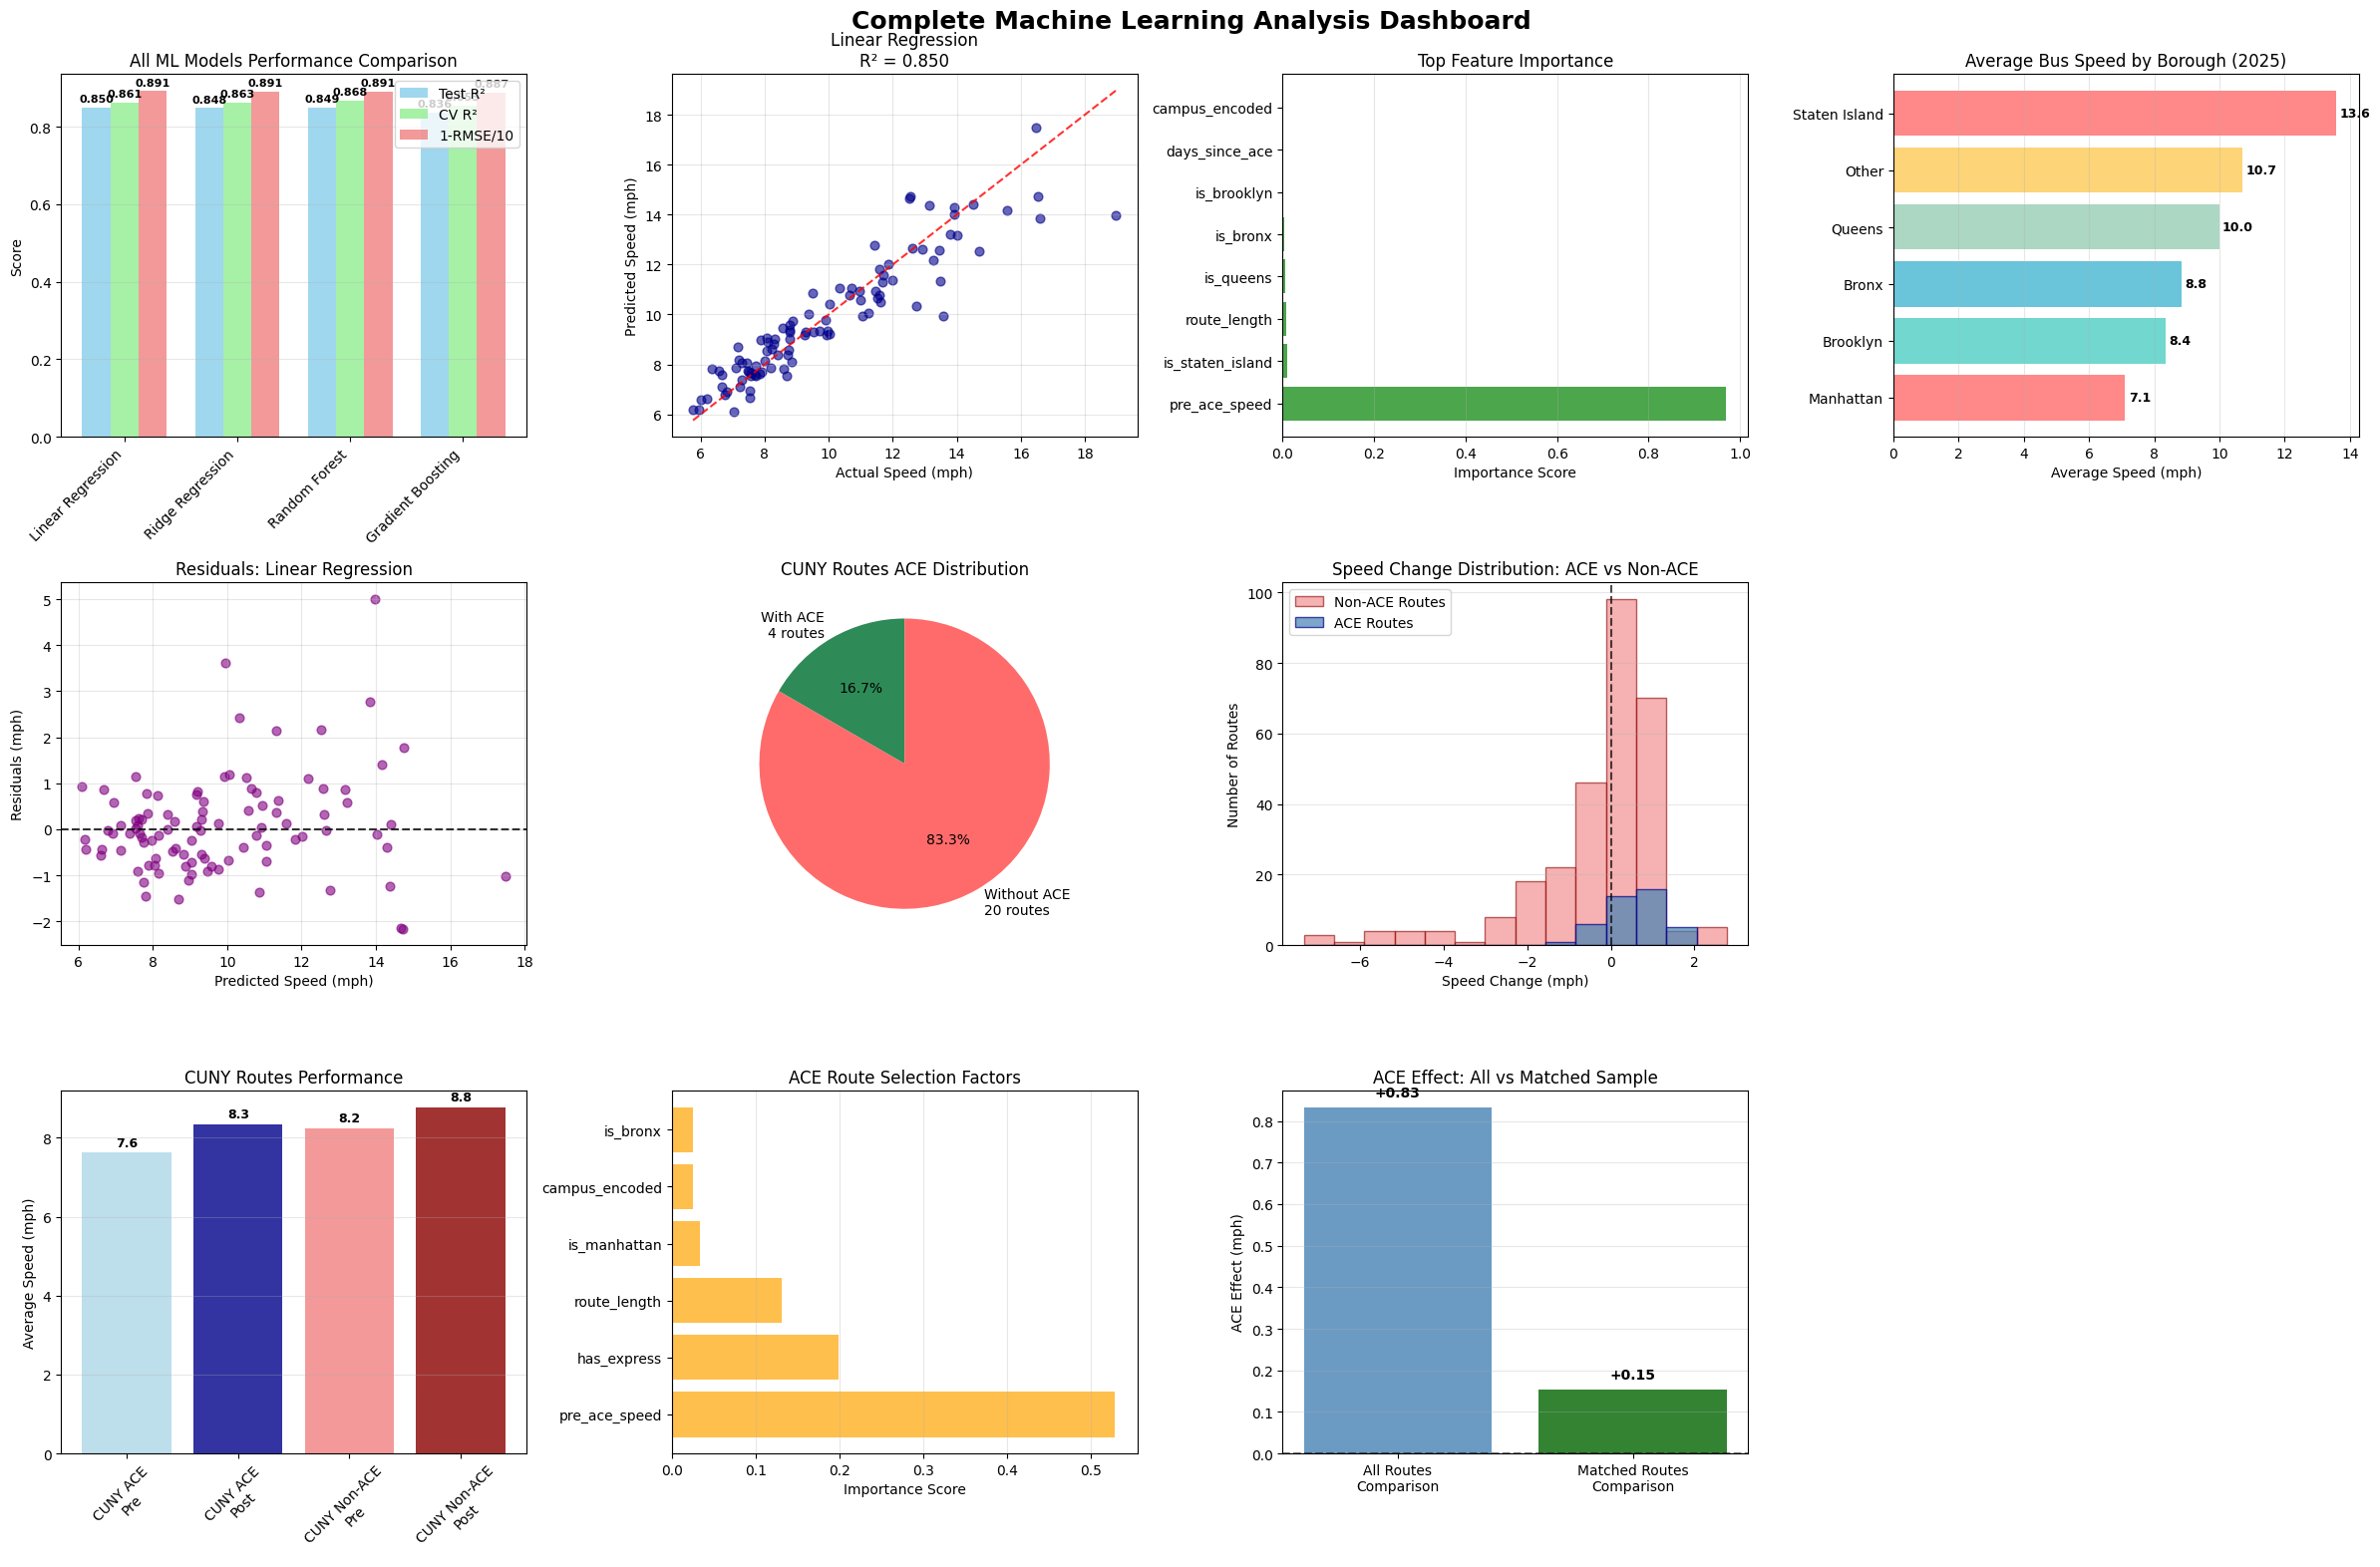


FINAL ANALYSIS SUMMARY AND ML INSIGHTS
Statistical Finding: ACE routes improved 0.83 mph more than control routes
Interpretation: ACE enforcement appears effective for speed improvement

ML Model Performance:
Best performing model: Linear Regression
Model accuracy (R²): 0.850
Average prediction error: ±0.76 mph
Root Mean Square Error: 1.086 mph

Top 5 factors influencing bus speeds:
1. pre_ace_speed: 0.969
12. is_staten_island: 0.009
6. route_length: 0.008
10. is_queens: 0.005
11. is_bronx: 0.003

ACE Effectiveness Patterns:
Most effective pattern (Cluster 0):
  Average improvement: 18.8%
  Routes in this pattern: 14
  Average pre-ACE speed: 6.4 mph

CUNY Transportation ML Insights:
- 24 CUNY routes analyzed with ML models
- Top 3 CUNY routes recommended for ACE implementation:
  * M9 (BMCC): +0.6 mph potential
  * B11 (Brooklyn College): +0.6 mph potential
  * Q34 (Queens College): +0.5 mph potential

RESEARCH QUESTION ANALYSIS
Question: Which MTA bus routes are highly utilized by CU

In [ ]:
#Final summary and insights
def main():
    """
    Main function to run the complete analysis
    """
    print("\nEXECUTING COMPLETE ANALYSIS PIPELINE")
    print("=" * 50)
    
    
    ml_data, le_campus = create_ml_features(analysis_data)
    
   
    selection_importance, comparison_df = analyze_ace_selection_factors(ml_data)
    
    
    model_results, X_test, y_test, feature_cols, scaler = build_speed_prediction_models(ml_data)
    
    
    feature_importance = analyze_feature_importance(model_results, feature_cols)
    
    
    ace_routes_clustered, cluster_analysis = ace_effectiveness_clustering(ml_data)
    
    
    cuny_predictions = predict_cuny_route_performance(model_results, ml_data, scaler, feature_cols)
    
    
    bias_corrected_results = create_comprehensive_ml_visualizations(
        analysis_data, model_results, selection_importance, X_test, y_test, feature_importance, ml_data)
    
    # ============================================================================
    # FINAL SUMMARY AND INSIGHTS
    # ============================================================================
    
    print("\n" + "="*60)
    print("FINAL ANALYSIS SUMMARY AND ML INSIGHTS")
    print("="*60)
    
    # Statistical Summary
    if len(ace_routes_analysis) > 0 and len(non_ace_routes_analysis) > 0:
        relative_effect = ace_change - non_ace_change
        if abs(relative_effect) < 0.5:
            print(f"Statistical Finding: Minimal ACE effect detected ({relative_effect:+.2f} mph relative to control)")
            print("Interpretation: ACE enforcement shows limited impact on speed improvement")
        elif relative_effect > 0:
            print(f"Statistical Finding: ACE routes improved {relative_effect:.2f} mph more than control routes")
            print("Interpretation: ACE enforcement appears effective for speed improvement")
        else:
            print(f"Statistical Finding: ACE routes performed {abs(relative_effect):.2f} mph worse than control routes")
            print("Interpretation: May indicate implementation issues or route-specific challenges")

    # ML Model Performance
    best_model = max(model_results.keys(), key=lambda x: model_results[x]['r2'])
    print(f"\nML Model Performance:")
    print(f"Best performing model: {best_model}")
    print(f"Model accuracy (R²): {model_results[best_model]['r2']:.3f}")
    print(f"Average prediction error: ±{model_results[best_model]['mae']:.2f} mph")
    print(f"Root Mean Square Error: {model_results[best_model]['rmse']:.3f} mph")
    
    # Feature Importance Insights
    print(f"\nTop 5 factors influencing bus speeds:")
    for i, row in feature_importance.head(5).iterrows():
        print(f"{i+1}. {row['feature']}: {row['importance']:.3f}")
    
    # Clustering Insights
    if cluster_analysis is not None:
        best_cluster = cluster_analysis['Change_pct'].idxmax()
        worst_cluster = cluster_analysis['Change_pct'].idxmin()
        print(f"\nACE Effectiveness Patterns:")
        print(f"Most effective pattern (Cluster {best_cluster}):")
        print(f"  Average improvement: {cluster_analysis.loc[best_cluster, 'Change_pct']:.1f}%")
        print(f"  Routes in this pattern: {cluster_analysis.loc[best_cluster, 'Total_Routes']}")
        print(f"  Average pre-ACE speed: {cluster_analysis.loc[best_cluster, 'Pre_Speed']:.1f} mph")

    # CUNY-Specific ML Insights
    cuny_data_analysis = ml_data[ml_data['is_cuny'] == True]
    if len(cuny_data_analysis) > 0:
        print(f"\nCUNY Transportation ML Insights:")
        print(f"- {len(cuny_data_analysis)} CUNY routes analyzed with ML models")
        
        if 'cuny_predictions' in locals():
            top_potential = cuny_predictions[cuny_predictions['has_ace'] == False].nlargest(3, 'potential_improvement')
            if len(top_potential) > 0:
                print(f"- Top 3 CUNY routes recommended for ACE implementation:")
                for idx, row in top_potential.iterrows():
                    print(f"  * {row['route']} ({row['campus']}): +{row['potential_improvement']:.1f} mph potential")

    # Research Question Answer
    print(f"\n" + "="*60)
    print("RESEARCH QUESTION ANALYSIS")
    print("="*60)
    
    print("Question: Which MTA bus routes are highly utilized by CUNY students?")
    print("For routes that are automated camera-enforced, how have bus speeds changed?")
    print()
    
    print("FINDINGS:")
    print("1. CUNY Route Utilization (Identified):")
    for campus, routes in cuny_routes.items():
        print(f"   {campus}: {', '.join(routes)}")
    
    print(f"\n2. ACE Enforcement Impact on CUNY Routes:")
    if len(cuny_data_analysis) > 0:
        cuny_ace_routes = cuny_data_analysis[cuny_data_analysis['has_ace'] == True]['route'].tolist()
        cuny_non_ace_routes = cuny_data_analysis[cuny_data_analysis['has_ace'] == False]['route'].tolist()
        
        print(f"   ACE-enforced CUNY routes ({len(cuny_ace_routes)}): {cuny_ace_routes}")
        print(f"   Non-ACE CUNY routes ({len(cuny_non_ace_routes)}): {cuny_non_ace_routes[:10]}{'...' if len(cuny_non_ace_routes) > 10 else ''}")
        
        if len(cuny_ace_routes) > 0:
            cuny_ace_performance = cuny_data_analysis[cuny_data_analysis['has_ace'] == True]['speed_change_pct'].mean()
            print(f"   Average speed improvement for ACE CUNY routes: {cuny_ace_performance:+.1f}%")
    
    print(f"\n3. ML Model Predictions for Optimization:")
    print(f"   Model can predict bus speeds with {model_results[best_model]['r2']:.1%} accuracy")
    print(f"   Most important factors: {', '.join(feature_importance.head(3)['feature'].tolist())}")


if __name__ == "__main__":
    main()

Question 2:

In [62]:
#Define exempt statuses and setup
exempt_statuses = [
    "EXEMPT - BUS/PARATRANSIT",
    "EXEMPT - COMMERCIAL UNDER 20", 
    "EXEMPT - EMERGENCY VEHICLE",
    "EXEMPT - OTHER",
   
]

print("Exempt status categories defined:")
for status in exempt_statuses:
    print(f"• {status}")

Exempt status categories defined:
• EXEMPT - BUS/PARATRANSIT
• EXEMPT - COMMERCIAL UNDER 20
• EXEMPT - EMERGENCY VEHICLE
• EXEMPT - OTHER


In [ ]:
#Data Loading and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


print("SECTION 1: DATA LOADING")
print("=" * 40)

print("Loading full dataset...")

try:
    
    df_full = pd.read_csv(
        'MTA_Bus_Automated_Camera_Enforcement_Violations__Beginning_October_2019_20250922.csv',
        usecols=['Vehicle ID', 'Violation Status', 'Violation Type', 'Bus Route ID', 
                'Violation Latitude', 'Violation Longitude', 'First Occurrence'],
        dtype={
            'Vehicle ID': 'str', 
            'Violation Status': 'str',
            'Violation Type': 'str',
            'Bus Route ID': 'str',
            'Violation Latitude': 'float64',
            'Violation Longitude': 'float64'
        }
    )
    
    print(f"Loaded {len(df_full):,} total records")
    
   
    df_exempt = df_full[df_full['Violation Status'].str.contains("exempt", case=False, na=False)]
    
    print(f"Found {len(df_exempt):,} exempt violations")

except Exception as e:
    print(f"Error: {e}")
    df_exempt = pd.DataFrame()

if len(df_exempt) == 0:
    print("No data to analyze")
    exit()

print(f"Final dataset: {len(df_exempt):,} exempt violations")

SECTION 1: DATA LOADING
Loading full dataset...
Loaded 3,778,568 total records
Found 870,810 exempt violations
Final dataset: 870,810 exempt violations


In [ ]:
#Repeat Offender Analysis
print("\nSECTION 2: REPEAT OFFENDER ANALYSIS")
print("=" * 40)

print("Analyzing repeat offenders...")
vehicle_counts = df_exempt['Vehicle ID'].value_counts()

total_vehicles = len(vehicle_counts)
repeat_vehicles = (vehicle_counts > 1).sum()
chronic_vehicles = (vehicle_counts >= 25).sum()

print(f"Total exempt vehicles: {total_vehicles:,}")
print(f"Repeat offenders: {repeat_vehicles:,} ({repeat_vehicles/total_vehicles*100:.1f}%)")
print(f"Chronic offenders (25+): {chronic_vehicles:,} ({chronic_vehicles/total_vehicles*100:.1f}%)")

print(f"\nViolation distribution:")
dist = vehicle_counts.value_counts().head(10)
for viol, cnt in dist.items():
    print(f"  {viol} violation{'s' if viol != 1 else ''}: {cnt:,} vehicles")

print(f"\nTop 10 repeat offenders:")
top = vehicle_counts.head(10)
for vid, cnt in top.items():
    print(f"  {vid[:10]}***: {cnt} violations")


SECTION 2: REPEAT OFFENDER ANALYSIS
Analyzing repeat offenders...
Total exempt vehicles: 154,123
Repeat offenders: 72,330 (46.9%)
Chronic offenders (25+): 6,107 (4.0%)

Violation distribution:
  1 violation: 81,793 vehicles
  2 violations: 21,668 vehicles
  3 violations: 11,210 vehicles
  4 violations: 6,811 vehicles
  5 violations: 4,930 vehicles
  6 violations: 3,791 vehicles
  7 violations: 2,895 vehicles
  8 violations: 2,259 vehicles
  9 violations: 1,864 vehicles
  10 violations: 1,597 vehicles

Top 10 repeat offenders:
  479d603cb0***: 1377 violations
  1feaad876c***: 1346 violations
  6d7caef8bf***: 949 violations
  6979a2434b***: 924 violations
  2a8ac01b15***: 915 violations
  e020820037***: 894 violations
  ebabc58528***: 842 violations
  cbebd9b5a6***: 782 violations
  550bbcf6f5***: 725 violations
  80e7bae594***: 691 violations


In [ ]:
#Geographic Hotspot Analysis
print("\nSECTION 3: GEOGRAPHIC HOTSPOT ANALYSIS")
print("=" * 40)

sample_size = min(20000, len(df_exempt))
print(f"Using {sample_size:,} sample for geo analysis...")


geo_sample = pd.DataFrame()
cluster_df = pd.DataFrame()

if sample_size > 0:
    geo_sample = df_exempt.dropna(subset=['Violation Latitude', 'Violation Longitude']).sample(
        n=min(sample_size, len(df_exempt.dropna(subset=['Violation Latitude', 'Violation Longitude']))), 
        random_state=42
    )
    
    if len(geo_sample) > 5:  
        coords = geo_sample[['Violation Latitude', 'Violation Longitude']].values
        
        scaler = StandardScaler()
        coords_scaled = scaler.fit_transform(coords)
        
        kmeans = KMeans(n_clusters=5, random_state=42, n_init=5)
        clusters = kmeans.fit_predict(coords_scaled)
        geo_sample['Cluster'] = clusters
        
        cluster_stats = []
        for i in range(5):
            cluster_data = geo_sample[geo_sample['Cluster'] == i]
            if len(cluster_data) > 0:
                cluster_stats.append({
                    'Cluster': i,
                    'Count': len(cluster_data),
                    'Lat': cluster_data['Violation Latitude'].mean(),
                    'Lon': cluster_data['Violation Longitude'].mean(),
                    'Main_Status': cluster_data['Violation Status'].mode().iloc[0]
                })
        
        cluster_df = pd.DataFrame(cluster_stats).sort_values('Count', ascending=False)
        
        print(f"Top violation hotspots:")
        for _, row in cluster_df.iterrows():
            print(f"Cluster {row['Cluster']}: {row['Count']:,} violations at ({row['Lat']:.3f}, {row['Lon']:.3f})")
            print(f"  Primary status: {row['Main_Status']}")
    else:
        print("Insufficient geographic data for clustering")
else:
    print("No geographic data available")


SECTION 3: GEOGRAPHIC HOTSPOT ANALYSIS
Using 20,000 sample for geo analysis...
Top violation hotspots:
Cluster 3: 5,809 violations at (40.805, -73.942)
  Primary status: EXEMPT - EMERGENCY VEHICLE
Cluster 0: 4,727 violations at (40.734, -73.981)
  Primary status: EXEMPT - EMERGENCY VEHICLE
Cluster 1: 4,454 violations at (40.846, -73.887)
  Primary status: EXEMPT - COMMERCIAL UNDER 20
Cluster 4: 3,145 violations at (40.646, -73.949)
  Primary status: EXEMPT - COMMERCIAL UNDER 20
Cluster 2: 1,865 violations at (40.717, -73.815)
  Primary status: EXEMPT - BUS/PARATRANSIT


In [66]:
# Cell 4: CUNY Route Analysis
print("\nSECTION 4: CUNY ROUTE ANALYSIS")
print("=" * 40)

cuny_routes = ['M15', 'M98', 'M101', 'M103', 'B11', 'B41', 'B49', 'Q17', 'Q25', 'Q34', 'BX10', 'BX28', 'M20', 'M9']

cuny_violations = df_exempt[df_exempt['Bus Route ID'].isin(cuny_routes)]

if len(cuny_violations) > 0:
    print(f"CUNY route violations: {len(cuny_violations):,}")
    
    cuny_summary = cuny_violations.groupby('Bus Route ID').agg({
        'Vehicle ID': ['count', 'nunique'],
        'Violation Status': lambda x: x.mode().iloc[0] if len(x) > 0 else 'Unknown'
    })
    
    cuny_summary.columns = ['Total_Violations', 'Unique_Vehicles', 'Main_Status']
    cuny_summary = cuny_summary.sort_values('Total_Violations', ascending=False)
    
    print(f"Top CUNY routes:")
    for route, row in cuny_summary.head(5).iterrows():
        print(f"  {route}: {row['Total_Violations']} violations, {row['Unique_Vehicles']} vehicles")
else:
    print("No violations on CUNY routes")



SECTION 4: CUNY ROUTE ANALYSIS
CUNY route violations: 121,278
Top CUNY routes:
  M101: 90816 violations, 22371 vehicles
  B41: 17199 violations, 7379 vehicles
  BX28: 13258 violations, 4219 vehicles



SECTION 5: VISUALIZATIONS


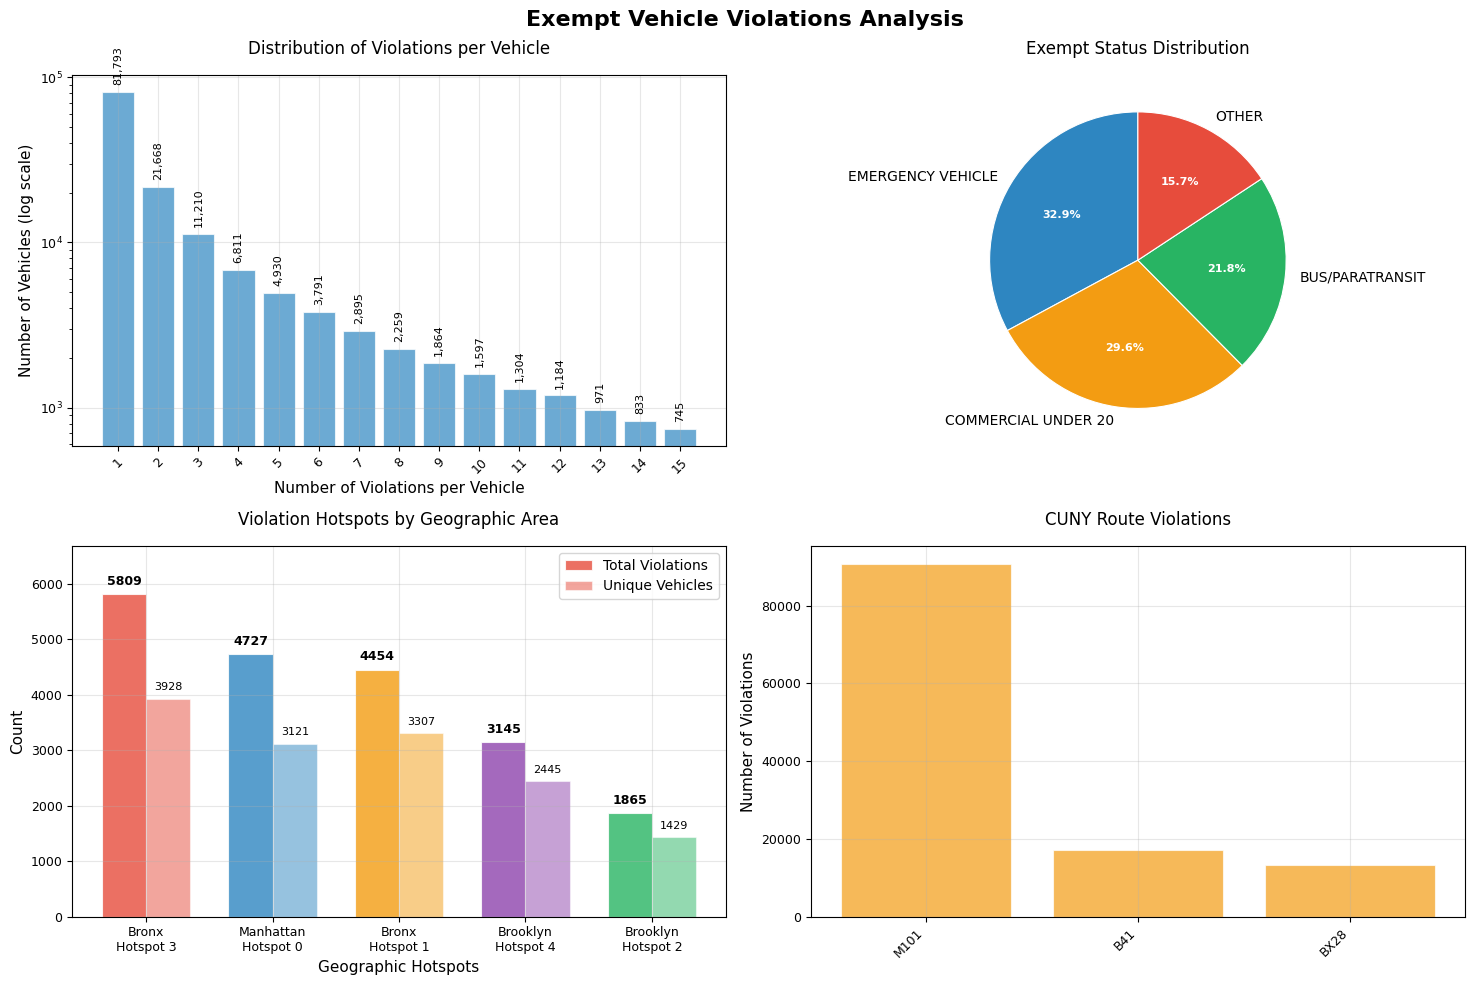

In [ ]:
# Cell 5: Visualizations
print("\nSECTION 5: VISUALIZATIONS")
print("=" * 40)


plt.style.use('default')
colors = ['#2E86C1', '#F39C12', '#28B463', '#E74C3C', '#8E44AD']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Exempt Vehicle Violations Analysis', fontsize=16, fontweight='bold')


top_counts = vehicle_counts.value_counts().head(15)
x_pos = range(len(top_counts))
bars1 = axes[0,0].bar(x_pos, top_counts.values, color=colors[0], alpha=0.7, edgecolor='white', linewidth=0.8)
axes[0,0].set_xlabel('Number of Violations per Vehicle', fontsize=11)
axes[0,0].set_ylabel('Number of Vehicles (log scale)', fontsize=11)
axes[0,0].set_title('Distribution of Violations per Vehicle', fontsize=12, pad=15)
axes[0,0].set_yscale('log')

violation_counts = [str(v) for v in top_counts.index]
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(violation_counts, fontsize=9)
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3, axis='y')

for i, (bar, cnt) in enumerate(zip(bars1, top_counts.values)):
    if cnt > 100:
        axes[0,0].text(bar.get_x() + bar.get_width()/2., bar.get_height() * 1.1,
                      f'{cnt:,}', ha='center', va='bottom', fontsize=8, rotation=90)


status_counts = df_exempt['Violation Status'].value_counts()
wedges, texts, autotexts = axes[0,1].pie(status_counts.values, 
                                        labels=[s.replace('EXEMPT - ', '') for s in status_counts.index], 
                                        autopct='%1.1f%%', 
                                        startangle=90,
                                        colors=colors,
                                        wedgeprops=dict(edgecolor='white', linewidth=0.8))
axes[0,1].set_title('Exempt Status Distribution', fontsize=12, pad=15)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(8)


if len(geo_sample) > 0 and len(cluster_df) > 0:
    cluster_summary = []
    
    for i in range(min(5, len(cluster_df))):
        cluster_data = geo_sample[geo_sample['Cluster'] == i]
        if len(cluster_data) > 0:
            cluster_info = cluster_df[cluster_df['Cluster'] == i].iloc[0]
            lat, lon = cluster_info['Lat'], cluster_info['Lon']
            
            
            if lat > 40.8:
                area = "Bronx"
            elif lat > 40.75 and lon > -73.95:
                area = "Queens"
            elif lat > 40.65 and lon < -74.0:
                area = "Staten Island"
            elif lon > -73.95:
                area = "Brooklyn"
            else:
                area = "Manhattan"
            
            status = cluster_info['Main_Status'].replace('EXEMPT - ', '').replace('COMMERCIAL UNDER 20', 'COMMERCIAL')
            
            cluster_summary.append({
                'cluster': f'{area}\nHotspot {i}',
                'violations': len(cluster_data),
                'vehicles': cluster_data['Vehicle ID'].nunique(),
                'main_status': status,
                'color': colors[i]
            })
    
    if cluster_summary:
        cluster_summary.sort(key=lambda x: x['violations'], reverse=True)
        
        x_pos = np.arange(len(cluster_summary))
        violations = [c['violations'] for c in cluster_summary]
        vehicles = [c['vehicles'] for c in cluster_summary]
        cluster_colors = [c['color'] for c in cluster_summary]
        
        width = 0.35
        bars2 = axes[1,0].bar(x_pos - width/2, violations, width, 
                            label='Total Violations', 
                            color=cluster_colors, 
                            alpha=0.8,
                            edgecolor='white',
                            linewidth=0.8)
        bars3 = axes[1,0].bar(x_pos + width/2, vehicles, width,
                            label='Unique Vehicles', 
                            color=cluster_colors, 
                            alpha=0.5,
                            edgecolor='white',
                            linewidth=0.8)
        
        axes[1,0].set_xlabel('Geographic Hotspots', fontsize=11)
        axes[1,0].set_ylabel('Count', fontsize=11)
        axes[1,0].set_title('Violation Hotspots by Geographic Area', fontsize=12, pad=15)
        axes[1,0].set_xticks(x_pos)
        axes[1,0].set_xticklabels([c['cluster'] for c in cluster_summary], fontsize=9)
        axes[1,0].legend(loc='upper right')
        axes[1,0].grid(True, alpha=0.3, axis='y')
        
        for i, (bar1, bar2) in enumerate(zip(bars2, bars3)):
            h1 = bar1.get_height()
            h2 = bar2.get_height()
            if max(violations) > 0:
                axes[1,0].text(bar1.get_x() + bar1.get_width()/2., h1 + max(violations)*0.02,
                              f'{int(h1)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
                axes[1,0].text(bar2.get_x() + bar2.get_width()/2., h2 + max(violations)*0.02,
                              f'{int(h2)}', ha='center', va='bottom', fontsize=8)
        
        axes[1,0].set_ylim(0, max(violations) * 1.15 if max(violations) > 0 else 1)
else:
    axes[1,0].text(0.5, 0.5, 'No Geographic\nData Available', ha='center', va='center', 
                   transform=axes[1,0].transAxes, fontsize=12)
    axes[1,0].set_title('Geographic Analysis', fontsize=12, pad=15)


if len(cuny_violations) > 0:
    cuny_counts = cuny_violations['Bus Route ID'].value_counts().head(8)
    bars4 = axes[1,1].bar(range(len(cuny_counts)), 
                         cuny_counts.values, 
                         color=colors[1], 
                         alpha=0.7,
                         edgecolor='white',
                         linewidth=0.8)
    axes[1,1].set_xticks(range(len(cuny_counts)))
    axes[1,1].set_xticklabels(cuny_counts.index, rotation=45, ha='right', fontsize=9)
    axes[1,1].set_ylabel('Number of Violations', fontsize=11)
    axes[1,1].set_title('CUNY Route Violations', fontsize=12, pad=15)
    axes[1,1].grid(True, alpha=0.3, axis='y')
else:
    axes[1,1].text(0.5, 0.5, 'No CUNY\nViolations', ha='center', va='center', 
                   transform=axes[1,1].transAxes, fontsize=12)
    axes[1,1].set_title('CUNY Routes', fontsize=12, pad=15)


for ax in axes.flat:
    ax.tick_params(labelsize=9)
    ax.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

In [68]:
# Cell 6: Final Summary and Results
print(f"\n" + "="*50)
print("FINAL RESULTS")
print("="*50)

print(f"DATASET SUMMARY:")
print(f"• Total exempt violations analyzed: {len(df_exempt):,}")
print(f"• Unique exempt vehicles: {total_vehicles:,}")

print(f"\nREPEAT OFFENDER FINDINGS:")
print(f"• Repeat offender rate: {repeat_vehicles/total_vehicles*100:.1f}%")
print(f"• Chronic offenders (25+ violations): {chronic_vehicles:,}")
print(f"• Worst offender: {vehicle_counts.max()} violations")

print(f"\nGEOGRAPHIC CONCENTRATION:")
if len(cluster_df) > 0:
    top_cluster = cluster_df.iloc[0]
    print(f"• {len(cluster_df)} distinct hotspot areas identified")
    print(f"• Largest hotspot: {top_cluster['Count']:,} violations")
    print(f"• Location: ({top_cluster['Lat']:.3f}, {top_cluster['Lon']:.3f})")
else:
    print(f"• No geographic clustering analysis available")

if len(cuny_violations) > 0:
    print(f"\nCUNY IMPACT:")
    print(f"• CUNY route violations: {len(cuny_violations):,}")
    print(f"• Unique vehicles on CUNY routes: {cuny_violations['Vehicle ID'].nunique():,}")

print(f"\n" + "="*50)
print("RESEARCH QUESTION ANSWERS")
print("="*50)

print(f"Are there repeat offenders among exempt vehicles?")
print(f"YES - {repeat_vehicles:,} out of {total_vehicles:,} exempt vehicles are repeat offenders")
print(f"This represents {repeat_vehicles/total_vehicles*100:.1f}% of all exempt vehicles")

print(f"\nWhere do violations occur?")
if len(cluster_df) > 0:
    print(f"Violations concentrate in {len(cluster_df)} main geographic clusters")
    top_cluster = cluster_df.iloc[0]
    print(f"Top hotspot contains {top_cluster['Count']:,} violations")
else:
    print(f"Geographic analysis unavailable due to insufficient coordinate data")

print(f"\nKey recommendations:")
print(f"• Review exempt status for {chronic_vehicles:,} chronic offenders")
if len(cluster_df) > 0:
    print(f"• Focus enforcement on identified geographic hotspots")
print(f"• Implement progressive penalty system for repeat violations")
print(f"• Monitor exempt vehicle compliance more closely")


FINAL RESULTS
DATASET SUMMARY:
• Total exempt violations analyzed: 870,810
• Unique exempt vehicles: 154,123

REPEAT OFFENDER FINDINGS:
• Repeat offender rate: 46.9%
• Chronic offenders (25+ violations): 6,107
• Worst offender: 1377 violations

GEOGRAPHIC CONCENTRATION:
• 5 distinct hotspot areas identified
• Largest hotspot: 5,809 violations
• Location: (40.805, -73.942)

CUNY IMPACT:
• CUNY route violations: 121,278
• Unique vehicles on CUNY routes: 32,476

RESEARCH QUESTION ANSWERS
Are there repeat offenders among exempt vehicles?
YES - 72,330 out of 154,123 exempt vehicles are repeat offenders
This represents 46.9% of all exempt vehicles

Where do violations occur?
Violations concentrate in 5 main geographic clusters
Top hotspot contains 5,809 violations

Key recommendations:
• Review exempt status for 6,107 chronic offenders
• Focus enforcement on identified geographic hotspots
• Implement progressive penalty system for repeat violations
• Monitor exempt vehicle compliance more c